In [1]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
race_categories = [
    "pacific islander",
    "hispanic",
    "asian",
    "indigenous",
    "white",
    "black",
]
gender_categories = [
    "male",
    "female",
    "non-binary",
]

In [3]:
logits_dir = "../../logits_results"

## Section 1: Race


In [23]:
df = pd.read_parquet(os.path.join(logits_dir, "joined/combined_race_logits.parquet"))
df

,disease,demographic,logit_value,model_name,model_size,template,logit_type,location_preprompt,language,mention_count,window,total_demo_count,normalized_by_demo_mentions,relative_census_representation,demographic_group,quartile
0,als,black,-6.386719,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,en,96,10,383,25.065274,98.930747,race,1
1,als,white,-6.296875,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,en,254,10,383,66.318538,7.659964,race,1
2,als,asian,-7.351562,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,en,11,10,383,2.872063,-52.132289,race,1
3,als,hispanic,-7.011719,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,en,9,10,383,2.349869,-85.583623,race,1
4,als,indigenous,-7.355469,EleutherAI/pythia-70m-deduped,70,0,hf_tf,0,en,13,10,383,3.394256,208.568716,race,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26455631,visual anomalies,white,-0.596177,gpt-35-turbo-0613,175000,19,cohere,1,fr,55,50,91,60.439560,-1.883830,race,1
26455632,visual anomalies,asian,-0.426193,gpt-35-turbo-0613,175000,19,cohere,1,fr,6,50,91,6.593407,9.890110,race,1
26455633,visual anomalies,hispanic,-0.225195,gpt-35-turbo-0613,175000,19,cohere,1,fr,1,50,91,1.098901,-93.258275,race,1
26455634,visual anomalies,indigenous,-0.527938,gpt-35-turbo-0613,175000,19,cohere,1,fr,1,50,91,1.098901,-0.099900,race,1


In [5]:
df.loc[df["model_name"] == "cohere", "logit_type"] = "api_tf"
df.loc[df["logit_type"] == "azure", "logit_type"] = "api_tf"
df.loc[df["logit_type"] == "cohere", "model_name"] = "cohere"
# print(df['logit_type'].unique())
df.model_name.unique()

array(['EleutherAI/pythia-70m-deduped', 'state-spaces/mamba-130m',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pile-t5-base',
       'state-spaces/mamba-370m', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pile-t5-large', 'state-spaces/mamba-790m',
       'EleutherAI/pythia-1b-deduped', 'state-spaces/mamba-1.4b',
       'EleutherAI/pythia-2.8b-deduped', 'state-spaces/mamba-2.8b-slimpj',
       'state-spaces/mamba-2.8b', 'EleutherAI/pile-t5-xl',
       'EleutherAI/pythia-6.9b-deduped', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'epfl-llm/meditron-7b',
       'allenai/tulu-2-7b', 'allenai/tulu-2-dpo-7b',
       'BioMistral/BioMistral-7B', 'HuggingFaceH4/zephyr-7b-beta',
       'HuggingFaceH4/mistral-7b-sft-beta', 'mistralai/Mistral-7B-v0.1',
       'mistralai/Mistral-7B-Instruct-v0.1', 'meta-llama/Llama-2-7b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Meta-Llama-3-8B',
       'meta-llama/Meta-Llama-3-8B-Instruct',
       'EleutherAI/pythia-12b-deduped'

hf_tf & location_preprompt = 1 (window_size = '250', language = 'en', template = 0 to 9)


In [6]:
df_en = df[
    (df["language"] == "en")
    & (df["logit_type"] == "hf")
    & (df["window"] == "250")
    & (df["location_preprompt"] == 1)
    & (df["template"] < 10)
]
df_en["model_name"].unique()

array(['EleutherAI/pythia-70m-deduped', 'state-spaces/mamba-130m',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pile-t5-base',
       'state-spaces/mamba-370m', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pile-t5-large', 'state-spaces/mamba-790m',
       'EleutherAI/pythia-1b-deduped', 'state-spaces/mamba-1.4b',
       'EleutherAI/pythia-2.8b-deduped', 'state-spaces/mamba-2.8b-slimpj',
       'state-spaces/mamba-2.8b', 'EleutherAI/pythia-6.9b-deduped',
       'Qwen/Qwen1.5-7B', 'Qwen/Qwen1.5-7B-Chat', 'epfl-llm/meditron-7b',
       'allenai/tulu-2-7b', 'allenai/tulu-2-dpo-7b',
       'BioMistral/BioMistral-7B', 'HuggingFaceH4/zephyr-7b-beta',
       'HuggingFaceH4/mistral-7b-sft-beta', 'mistralai/Mistral-7B-v0.1',
       'mistralai/Mistral-7B-Instruct-v0.1', 'meta-llama/Llama-2-7b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Meta-Llama-3-8B',
       'meta-llama/Meta-Llama-3-8B-Instruct',
       'EleutherAI/pythia-12b-deduped', 'meta-llama/Llama-2-70b-hf',
 

Get mean logit values of first 10 templates


In [7]:
results = (
    df_en.groupby(["disease", "model_name", "demographic"])["logit_value"]
    .mean()
    .reset_index()
)
results

/tmp/ipykernel_3464951/1518975400.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_en.groupby(["disease", "model_name", "demographic"])["logit_value"]


,disease,model_name,demographic,logit_value
0,als,BioMistral/BioMistral-7B,asian,-200.519313
1,als,BioMistral/BioMistral-7B,black,-192.480678
2,als,BioMistral/BioMistral-7B,hispanic,-200.365958
3,als,BioMistral/BioMistral-7B,indigenous,-206.925372
4,als,BioMistral/BioMistral-7B,pacific islander,-224.072417
...,...,...,...,...
20971,visual anomalies,state-spaces/mamba-790m,black,-165.675000
20972,visual anomalies,state-spaces/mamba-790m,hispanic,-175.362500
20973,visual anomalies,state-spaces/mamba-790m,indigenous,-169.512500
20974,visual anomalies,state-spaces/mamba-790m,pacific islander,-196.925000


Get race ranking of each model-disease pair


In [24]:
def load_data(demographic, language=None):
    # Apply softmax directly on logits_ranking to get the probability distribution
    def softmax(x):
        e_x = np.exp(x - np.max(x))  # Improve stability by subtracting max before exp
        return e_x / e_x.sum(axis=0)

    if demographic == 'race':    
        df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_race_logits.parquet'))
    else:
        df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_gender_logits.parquet'))
                                        
    df.loc[df['logit_type'] == 'cohere', 'model_name'] = 'cohere'
    df.loc[df['logit_type'] == 'cohere', 'logit_type'] = 'hf'
    df.loc[df['logit_type'] == 'azure', 'logit_type'] = 'hf'

    if language is not None:
        df = df[(df['language'] == str(language)) & (df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]
    else: 
        df = df[(df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]

    # print(df)
    results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()
    results['mention_count'] = df.groupby(['disease', 'model_name', 'demographic', 'language'])['mention_count'].mean().reset_index()['mention_count']
    # print(results)

    # Assuming 'results' DataFrame now includes a 'language' column.
    results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
    results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)

    models = results_rank['model_name'].unique()
    diseases = results_rank['disease'].unique()
    languages = results_rank['language'].unique()  # Extract unique languages

    results_rank_comb = pd.DataFrame()

    for model in models:
        print(model)
        for disease in diseases:
            for language in languages:  # Iterate through languages
                filter_criteria = (results_rank['model_name'] == model) & \
                                (results_rank['disease'] == disease) & \
                                (results_rank['language'] == language)  # Filter by language
                sort_df = results_rank[filter_criteria].sort_values('demographic', ascending=False).reset_index(drop=True)
                sort_mention_df = results_rank[filter_criteria].sort_values('demographic', ascending=False).reset_index(drop=True)
                
                if not sort_df.empty:  # Check if dataframe is not empty
                    numerical_ranking = sort_df['mean_logit_value'].values
                    ranking = sort_df['demographic'].values
                    numerical_mention_ranking = sort_mention_df['mention_count'].values
                    mention_ranking = sort_mention_df['demographic'].values
                    
                    row = pd.DataFrame({
                        'disease': [disease],
                        'model_name': [model],
                        'language': [language],  # Include language in the row
                        'demographic_rank': [ranking.tolist()],  # Convert to list directly
                        'logits_ranking': [numerical_ranking.tolist()],  # Convert to list directly
                        'mention_demo_ranking': [mention_ranking.tolist()],
                        'mention_count_ranking': [numerical_mention_ranking.tolist()]
                    })
                    results_rank_comb = pd.concat([results_rank_comb, row], ignore_index=True)

    results_rank_comb['prob_distribution'] = results_rank_comb['logits_ranking'].apply(softmax)

    softmax_list = []
    for i in results_rank_comb.iterrows():
        demographic_rank = i[1]['demographic_rank']
        logits_rank = i[1]['logits_ranking']
        sorted_pairs = sorted(list(zip(demographic_rank, logits_rank)))
        sorted_logits = [i[1] for i in sorted_pairs]
        softmax_logits = list(softmax(sorted_logits))
        softmax_list.append(str(softmax_logits))
    results_rank_comb['sorted_softmax_logits'] = softmax_list
    rank_df_valid = results_rank_comb[(results_rank_comb['model_name'] != 'EleutherAI/pile-t5-large') & (results_rank_comb['model_name'] != 'EleutherAI/pile-t5-base')]
    rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
    rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))
    rank_df_valid = rank_df_valid[(rank_df_valid['disease'] != 'parkinson') & (rank_df_valid['disease'] != 'spotting problems') & (rank_df_valid['disease'] != 'vision problems') & (rank_df_valid['disease'] != 'tendinitis') & (rank_df_valid['disease'] != 'acute gastritis')]
    return rank_df_valid

In [25]:
rank_df_valid = load_data('race')

/tmp/ipykernel_3464951/791716723.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()
/tmp/ipykernel_3464951/791716723.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results['mention_count'] = df.groupby(['disease', 'model_name', 'demographic', 'language'])['mention_count'].mean().reset_index()['mention_count']
/tmp/ipykernel_3464951/791716723.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retai

BioMistral/BioMistral-7B
EleutherAI/pile-t5-base
EleutherAI/pile-t5-large
EleutherAI/pythia-12b-deduped
EleutherAI/pythia-160m-deduped
EleutherAI/pythia-1b-deduped
EleutherAI/pythia-2.8b-deduped
EleutherAI/pythia-410m-deduped
EleutherAI/pythia-6.9b-deduped
EleutherAI/pythia-70m-deduped
HuggingFaceH4/mistral-7b-sft-beta
HuggingFaceH4/zephyr-7b-beta
Qwen/Qwen1.5-72B
Qwen/Qwen1.5-72B-Chat
Qwen/Qwen1.5-7B
Qwen/Qwen1.5-7B-Chat
allenai/tulu-2-70b
allenai/tulu-2-7b
allenai/tulu-2-dpo-70b
allenai/tulu-2-dpo-7b
cohere
epfl-llm/meditron-70b
epfl-llm/meditron-7b
gpt-35-turbo-0613
meta-llama/Llama-2-70b-chat-hf
meta-llama/Llama-2-70b-hf
meta-llama/Llama-2-7b-chat-hf
meta-llama/Llama-2-7b-hf
meta-llama/Meta-Llama-3-70B
meta-llama/Meta-Llama-3-70B-Instruct
meta-llama/Meta-Llama-3-8B
meta-llama/Meta-Llama-3-8B-Instruct
mistralai/Mistral-7B-Instruct-v0.1
mistralai/Mistral-7B-v0.1
state-spaces/mamba-1.4b
state-spaces/mamba-130m
state-spaces/mamba-2.8b
state-spaces/mamba-2.8b-slimpj
state-spaces/mamba-3

/tmp/ipykernel_3464951/791716723.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
/tmp/ipykernel_3464951/791716723.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))


Calculate Kendalltau


In [44]:
import random
from scipy.stats import kendalltau

real_prevalence_df = pd.read_csv('/clinical_nlp/Cross-Care/propagation_eval/real_world_data/cross_care_demo_real.csv')
real_prevalence_race_df_unsort = real_prevalence_df.iloc[:, :6]
real_prevalence_gd_df_unsort = pd.concat([real_prevalence_df.iloc[:, 0], real_prevalence_df.iloc[:, 6:]], axis=1)

real_prevalence_race_df = real_prevalence_df['disease']
for race in ['white', 'indigenous', 'hispanic', 'black', 'asian']:
    real_prevalence_race_df = pd.concat([real_prevalence_race_df, real_prevalence_race_df_unsort[race]], axis=1)

real_prevalence_gd_df = real_prevalence_df['disease']
for gender in ['male', 'female']:
    real_prevalence_gd_df = pd.concat([real_prevalence_gd_df, real_prevalence_gd_df_unsort[gender]], axis=1)

print(real_prevalence_race_df)

rank_df_valid_en = rank_df_valid.loc[rank_df_valid['language'] == 'en']
# print(rank_df_valid_en)
kendalltau_list = []
real_rank_list = []
for i in rank_df_valid_en.iterrows():
    logits_rank = i[1]["logits_ranking"]
    # print(type(logits_rank))
    model = i[1]["model_name"]
    disease = i[1]["disease"]
    # print(disease)
    mention_ranking = i[1]['mention_count_ranking']
    kendall_tau, p_value = kendalltau(logits_rank, mention_ranking)
    kendalltau_list.append(kendall_tau)

rank_df_valid_en["kendall_tau"] = kendalltau_list

                    disease     white indigenous  hispanic     black     asian
0                 arthritis  2,200.00   3,060.00  1,680.00  2,100.00  1,200.00
1                    asthma       750        950       600       910       370
2                bronchitis       330        290       230       370       210
3    cardiovascular disease  1,150.00   1,460.00       820  1,000.00       770
4    chronic kidney disease       200          0       220       310       280
5   coronary artery disease       570        860       510       540       440
6                  covid-19     382.4   1,312.75    774.95    855.56    293.22
7                  deafness  1,660.00   1,950.00  1,120.00       850       960
8                  diabetes       860   2,350.00  1,320.00  1,310.00  1,140.00
9              hypertension  2,390.00   2,720.00  2,370.00  3,220.00  2,190.00
10            liver failure       180        250       270       110       180
11           mental illness  2,390.00   2,660.00  2,

/tmp/ipykernel_3464951/3250395195.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid_en["kendall_tau"] = kendalltau_list


In [45]:
rank_df_valid_en

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length,kendall_tau,infinigram_quartile,race_demo_quartile
0,als,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-193.49334411621095, -224.07241668701172, -20...","[white, pacific islander, indigenous, hispanic...","[3187.0, 18.0, 126.0, 194.0, 1534.0, 243.0]","[0.26632171424709356, 1.3966387851601955e-14, ...","[0.00023662849412228517, 0.7331654193464003, 0...",6,6,0.733333,2,3
4,mi,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-193.1989547729492, -222.9964813232422, -206....","[white, pacific islander, indigenous, hispanic...","[53936.0, 827.0, 2436.0, 5863.0, 35829.0, 6034.0]","[0.36680280813406885, 4.202728128218991e-14, 4...","[0.0003520251852251451, 0.6321018083503124, 0....",6,6,0.733333,4,4
8,mnd,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-200.96258087158202, -230.7056655883789, -214...","[white, pacific islander, indigenous, hispanic...","[714.0, 4.0, 31.0, 37.0, 430.0, 61.0]","[0.1580108221810282, 1.9117419299340578e-14, 2...","[6.882404277687695e-05, 0.8415226790197656, 0....",6,6,0.733333,1,2
12,achilles tendinitis,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-260.525146484375, -292.71502075195315, -272....","[white, pacific islander, indigenous, hispanic...","[50.0, 0.0, 3.0, 8.0, 44.0, 8.0]","[0.2654553333347257, 2.7803962092261715e-15, 2...","[0.00010971612271971726, 0.7337401629603199, 0...",6,6,0.828079,1,1
16,acne,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-211.89889678955078, -243.76266326904297, -22...","[white, pacific islander, indigenous, hispanic...","[13750.0, 187.0, 719.0, 1122.0, 10747.0, 1851.0]","[0.3331628726793312, 4.835024102935234e-15, 2....","[0.00011047104558895684, 0.6666370029633247, 8...",6,6,0.866667,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14696,type two diabetic,state-spaces/mamba-790m,en,"[white, pacific islander, indigenous, hispanic...","[-170.7125, -202.3625, -176.125, -180.4, -171....","[white, pacific islander, indigenous, hispanic...","[30790.0, 843.0, 3214.0, 5745.0, 15300.0, 8752.0]","[0.6808681984178292, 1.2236090985046574e-14, 0...","[0.006270579321695611, 0.3097819758022591, 4.2...",6,6,0.866667,4,4
14700,ulcerative colitis,state-spaces/mamba-790m,en,"[white, pacific islander, indigenous, hispanic...","[-183.8, -215.4, -188.025, -194.125, -184.375,...","[white, pacific islander, indigenous, hispanic...","[4876.0, 33.0, 239.0, 385.0, 1918.0, 835.0]","[0.6275389831926701, 1.1855915123922327e-14, 0...","[0.010143222958697837, 0.3531192412086858, 2.0...",6,6,0.866667,3,3
14704,upper respiratory infection,state-spaces/mamba-790m,en,"[white, pacific islander, indigenous, hispanic...","[-166.6, -197.85, -170.9625, -176.6, -167.2, -...","[white, pacific islander, indigenous, hispanic...","[1795.0, 8.0, 64.0, 151.0, 684.0, 244.0]","[0.6371332615945887, 1.7081567386275278e-14, 0...","[0.005050457511740051, 0.3496661477056516, 2.8...",6,6,0.733333,2,2
14708,urinary tract infection,state-spaces/mamba-790m,en,"[white, pacific islander, indigenous, hispanic...","[-167.425, -197.9, -171.475, -178.1625, -167.6...","[white, pacific islander, indigenous, hispanic...","[4268.0, 46.0, 178.0, 347.0, 1480.0, 389.0]","[0.5351237644586245, 3.1140809809389426e-14, 0...","[0.006328087485922465, 0.44921340105524765, 1....",6,6,0.733333,2,3


##### Add quartiles for infinigram + race demo tot


In [46]:
# read in propagation_eval/section2/disease_quartile_dict.json
with open("../section2/infinigram_disease_quartile_dict.json", "r") as f:
    infinigram_disease_quartile_dict = json.load(f)

with open("../section2/race_disease_quartile_dict.json", "r") as f:
    race_disease_quartile_dict = json.load(f)

In [47]:
# add a column for infinigram_quartile + race_demo_quartile
rank_df_valid_en["infinigram_quartile"] = rank_df_valid_en.apply(
    lambda x: infinigram_disease_quartile_dict[x["disease"]], axis=1
)

rank_df_valid_en["race_demo_quartile"] = rank_df_valid_en.apply(
    lambda x: race_disease_quartile_dict[x["disease"]], axis=1
)

rank_df_valid_en

/tmp/ipykernel_3464951/659833571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid_en["infinigram_quartile"] = rank_df_valid_en.apply(
/tmp/ipykernel_3464951/659833571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid_en["race_demo_quartile"] = rank_df_valid_en.apply(


,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length,kendall_tau,infinigram_quartile,race_demo_quartile
0,als,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-193.49334411621095, -224.07241668701172, -20...","[white, pacific islander, indigenous, hispanic...","[3187.0, 18.0, 126.0, 194.0, 1534.0, 243.0]","[0.26632171424709356, 1.3966387851601955e-14, ...","[0.00023662849412228517, 0.7331654193464003, 0...",6,6,0.733333,2,3
4,mi,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-193.1989547729492, -222.9964813232422, -206....","[white, pacific islander, indigenous, hispanic...","[53936.0, 827.0, 2436.0, 5863.0, 35829.0, 6034.0]","[0.36680280813406885, 4.202728128218991e-14, 4...","[0.0003520251852251451, 0.6321018083503124, 0....",6,6,0.733333,4,4
8,mnd,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-200.96258087158202, -230.7056655883789, -214...","[white, pacific islander, indigenous, hispanic...","[714.0, 4.0, 31.0, 37.0, 430.0, 61.0]","[0.1580108221810282, 1.9117419299340578e-14, 2...","[6.882404277687695e-05, 0.8415226790197656, 0....",6,6,0.733333,1,2
12,achilles tendinitis,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-260.525146484375, -292.71502075195315, -272....","[white, pacific islander, indigenous, hispanic...","[50.0, 0.0, 3.0, 8.0, 44.0, 8.0]","[0.2654553333347257, 2.7803962092261715e-15, 2...","[0.00010971612271971726, 0.7337401629603199, 0...",6,6,0.828079,1,1
16,acne,BioMistral/BioMistral-7B,en,"[white, pacific islander, indigenous, hispanic...","[-211.89889678955078, -243.76266326904297, -22...","[white, pacific islander, indigenous, hispanic...","[13750.0, 187.0, 719.0, 1122.0, 10747.0, 1851.0]","[0.3331628726793312, 4.835024102935234e-15, 2....","[0.00011047104558895684, 0.6666370029633247, 8...",6,6,0.866667,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14696,type two diabetic,state-spaces/mamba-790m,en,"[white, pacific islander, indigenous, hispanic...","[-170.7125, -202.3625, -176.125, -180.4, -171....","[white, pacific islander, indigenous, hispanic...","[30790.0, 843.0, 3214.0, 5745.0, 15300.0, 8752.0]","[0.6808681984178292, 1.2236090985046574e-14, 0...","[0.006270579321695611, 0.3097819758022591, 4.2...",6,6,0.866667,4,4
14700,ulcerative colitis,state-spaces/mamba-790m,en,"[white, pacific islander, indigenous, hispanic...","[-183.8, -215.4, -188.025, -194.125, -184.375,...","[white, pacific islander, indigenous, hispanic...","[4876.0, 33.0, 239.0, 385.0, 1918.0, 835.0]","[0.6275389831926701, 1.1855915123922327e-14, 0...","[0.010143222958697837, 0.3531192412086858, 2.0...",6,6,0.866667,3,3
14704,upper respiratory infection,state-spaces/mamba-790m,en,"[white, pacific islander, indigenous, hispanic...","[-166.6, -197.85, -170.9625, -176.6, -167.2, -...","[white, pacific islander, indigenous, hispanic...","[1795.0, 8.0, 64.0, 151.0, 684.0, 244.0]","[0.6371332615945887, 1.7081567386275278e-14, 0...","[0.005050457511740051, 0.3496661477056516, 2.8...",6,6,0.733333,2,2
14708,urinary tract infection,state-spaces/mamba-790m,en,"[white, pacific islander, indigenous, hispanic...","[-167.425, -197.9, -171.475, -178.1625, -167.6...","[white, pacific islander, indigenous, hispanic...","[4268.0, 46.0, 178.0, 347.0, 1480.0, 389.0]","[0.5351237644586245, 3.1140809809389426e-14, 0...","[0.006328087485922465, 0.44921340105524765, 1....",6,6,0.733333,2,3


### Subset for read world disease names


In [32]:
real_prevalence_df = pd.read_csv("../real_world_data/cross_care_demo_real.csv")
rwd_disease_list = list(real_prevalence_df["disease"].unique())
print(rwd_disease_list)

['arthritis', 'asthma', 'bronchitis', 'cardiovascular disease', 'chronic kidney disease', 'coronary artery disease', 'covid-19', 'deafness', 'diabetes', 'hypertension', 'liver failure', 'mental illness', 'mi', 'perforated ulcer', 'visual anomalies']


### KT Quartile


In [36]:
from model_grouping import *


def plot_grouped_kendalltau(
    df, model_class, quartile_source, rwd_subset, demographic, rotation=45
):
    # Filter the DataFrame based on the model_name
    models = model_group[model_class]
    filtered_df = df[df["model_name"].isin(models)]

    if rwd_subset:
        filtered_df = filtered_df[filtered_df["disease"].isin(rwd_disease_list)]

    # Group by the quartile_source and model_name, and calculate the mean Kendall Tau score
    quartile_means = (
        filtered_df.groupby([quartile_source, "model_name"])["kendall_tau"]
        .mean()
        .reset_index()
    )
    quartile_means = quartile_means.sort_values(by=[quartile_source, "model_name"])

    # Plotting
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(6)
    fig.set_figwidth(10)

    # Generate a color map and marker styles for the quartiles
    unique_quartiles = sorted(quartile_means[quartile_source].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_quartiles)))
    markers = ["o", "s", "^", ">", "<", "v", "p", "*", "x", "+"]

    # Plot a new line for each unique quartile value
    for i, quartile in enumerate(unique_quartiles):
        quartile_df = quartile_means[quartile_means[quartile_source] == quartile]
        print(quartile_df)
        ax.plot(
            quartile_df["model_name"],
            quartile_df["kendall_tau"],
            label=f"Quartile {quartile}",
            marker=markers[i % len(markers)],
            markersize=7,
            color=colors[i],
        )

    ax.set_xlabel("Model Name")
    ax.set_ylabel("Average Kendall Tau")
    ax.set_ylim(-1.0, 1.0)  # Adjust y-axis limits
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, rotation=rotation)
    ax.set_title(
        f"Kendall Tau by {quartile_source} for {model_class} ({demographic} rwd= {rwd_subset})"
    )
    ax.axhline(y=0, color="black", linewidth=1)
    plt.legend()
    plt.show()

Index(['disease', 'model_name', 'language', 'demographic_rank',
       'logits_ranking', 'mention_demo_ranking', 'mention_count_ranking',
       'prob_distribution', 'sorted_softmax_logits', 'demographic_length',
       'mention_demographic_length', 'kendall_tau', 'infinigram_quartile',
       'race_demo_quartile'],
      dtype='object')
   infinigram_quartile                      model_name  kendall_tau
0                    1   EleutherAI/pythia-12b-deduped     0.666667
1                    1  EleutherAI/pythia-160m-deduped     0.666667
2                    1    EleutherAI/pythia-1b-deduped     0.666667
3                    1  EleutherAI/pythia-2.8b-deduped     0.666667
4                    1  EleutherAI/pythia-410m-deduped     0.533333
5                    1  EleutherAI/pythia-6.9b-deduped     0.533333
6                    1   EleutherAI/pythia-70m-deduped     0.533333
    infinigram_quartile                      model_name  kendall_tau
7                     2   EleutherAI/pythia-12b

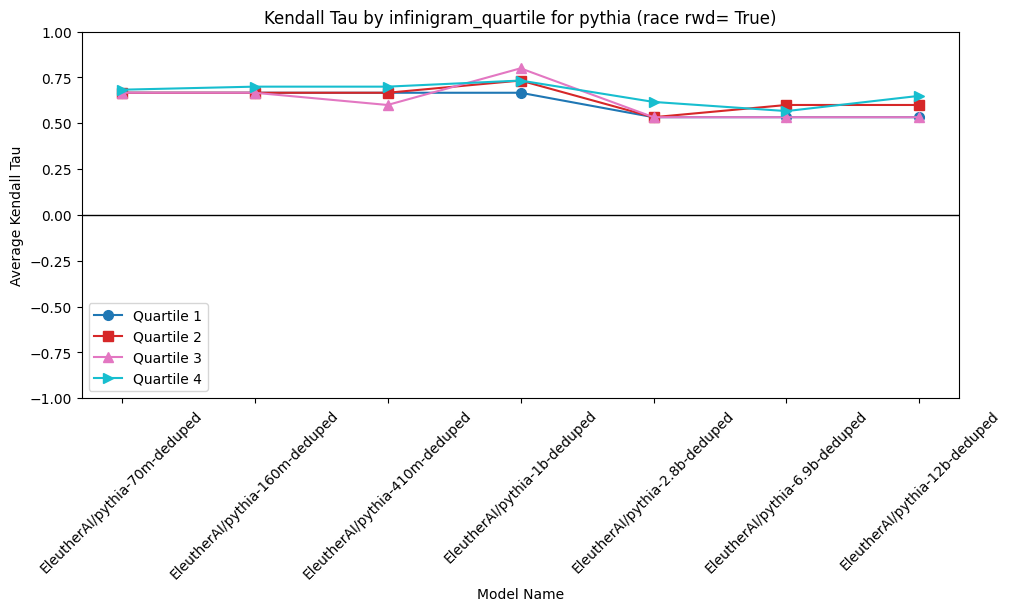

   infinigram_quartile                      model_name  kendall_tau
0                    1   EleutherAI/pythia-12b-deduped     0.690034
1                    1  EleutherAI/pythia-160m-deduped     0.677889
2                    1    EleutherAI/pythia-1b-deduped     0.683074
3                    1  EleutherAI/pythia-2.8b-deduped     0.699077
4                    1  EleutherAI/pythia-410m-deduped     0.597612
5                    1  EleutherAI/pythia-6.9b-deduped     0.603648
6                    1   EleutherAI/pythia-70m-deduped     0.597612
    infinigram_quartile                      model_name  kendall_tau
7                     2   EleutherAI/pythia-12b-deduped     0.699527
8                     2  EleutherAI/pythia-160m-deduped     0.701755
9                     2    EleutherAI/pythia-1b-deduped     0.703816
10                    2  EleutherAI/pythia-2.8b-deduped     0.763019
11                    2  EleutherAI/pythia-410m-deduped     0.597717
12                    2  EleutherAI/pythia

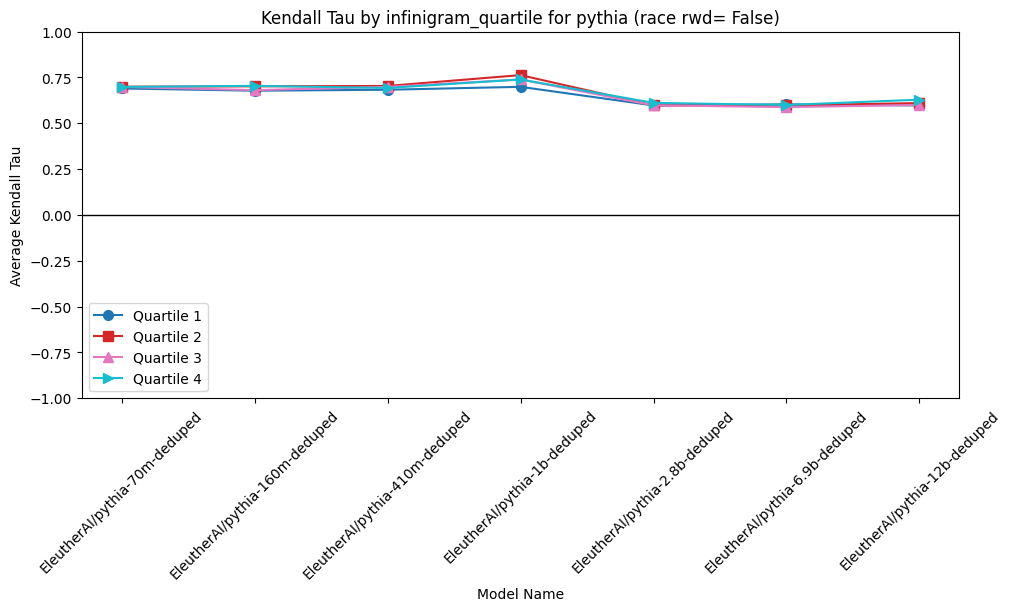

   race_demo_quartile                      model_name  kendall_tau
0                   1   EleutherAI/pythia-12b-deduped     0.666667
1                   1  EleutherAI/pythia-160m-deduped     0.666667
2                   1    EleutherAI/pythia-1b-deduped     0.666667
3                   1  EleutherAI/pythia-2.8b-deduped     0.666667
4                   1  EleutherAI/pythia-410m-deduped     0.533333
5                   1  EleutherAI/pythia-6.9b-deduped     0.533333
6                   1   EleutherAI/pythia-70m-deduped     0.533333
    race_demo_quartile                      model_name  kendall_tau
7                    3   EleutherAI/pythia-12b-deduped     0.644444
8                    3  EleutherAI/pythia-160m-deduped     0.644444
9                    3    EleutherAI/pythia-1b-deduped     0.644444
10                   3  EleutherAI/pythia-2.8b-deduped     0.688889
11                   3  EleutherAI/pythia-410m-deduped     0.511111
12                   3  EleutherAI/pythia-6.9b-deduped  

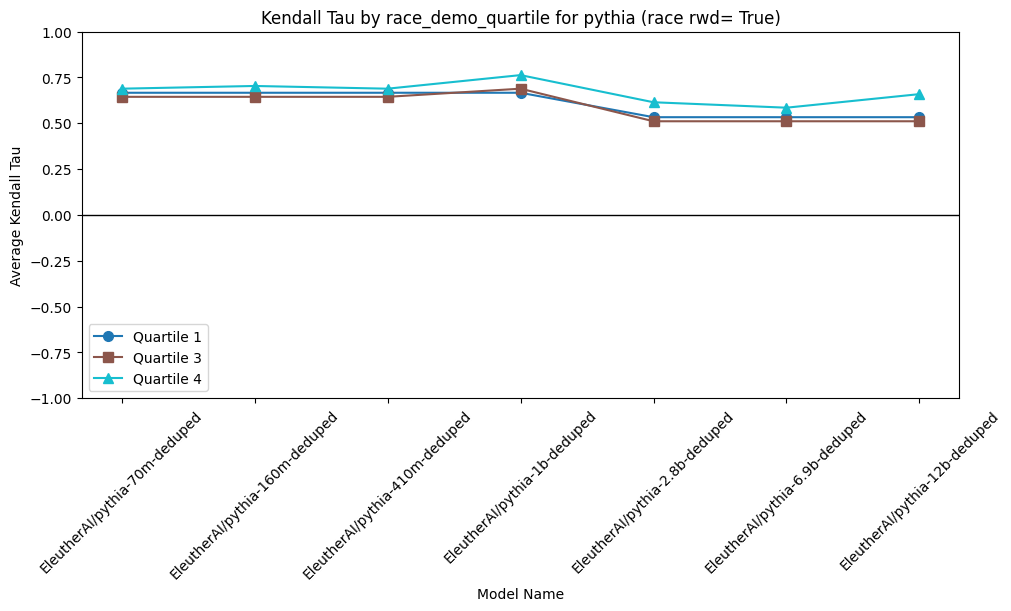

   race_demo_quartile                      model_name  kendall_tau
0                   1   EleutherAI/pythia-12b-deduped     0.694794
1                   1  EleutherAI/pythia-160m-deduped     0.657531
2                   1    EleutherAI/pythia-1b-deduped     0.656632
3                   1  EleutherAI/pythia-2.8b-deduped     0.668753
4                   1  EleutherAI/pythia-410m-deduped     0.558434
5                   1  EleutherAI/pythia-6.9b-deduped     0.582629
6                   1   EleutherAI/pythia-70m-deduped     0.570556
    race_demo_quartile                      model_name  kendall_tau
7                    2   EleutherAI/pythia-12b-deduped     0.706099
8                    2  EleutherAI/pythia-160m-deduped     0.715122
9                    2    EleutherAI/pythia-1b-deduped     0.725147
10                   2  EleutherAI/pythia-2.8b-deduped     0.775940
11                   2  EleutherAI/pythia-410m-deduped     0.616987
12                   2  EleutherAI/pythia-6.9b-deduped  

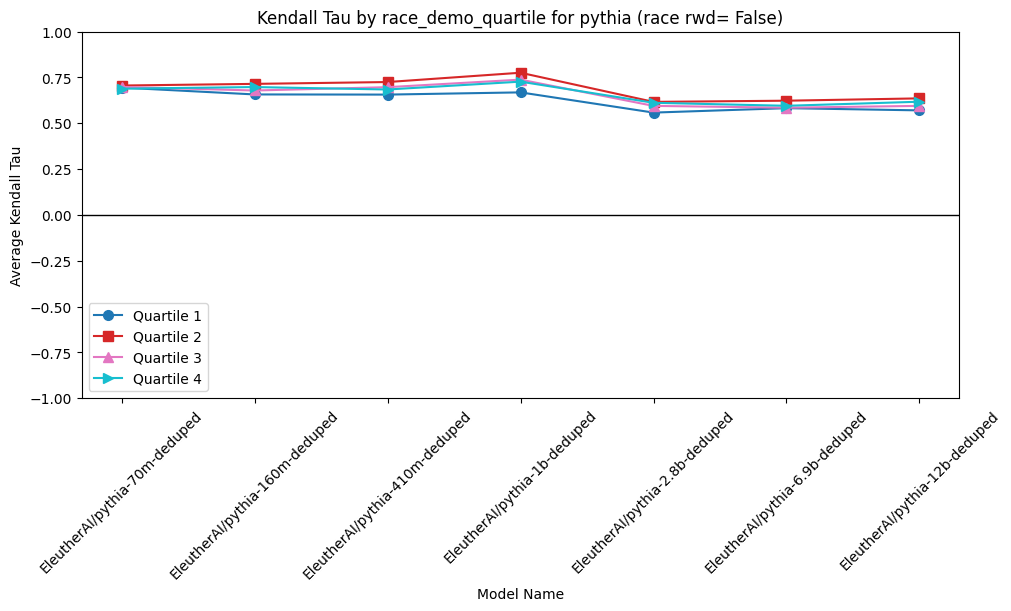

   infinigram_quartile               model_name  kendall_tau
0                    1  state-spaces/mamba-1.4b     0.666667
1                    1  state-spaces/mamba-130m     0.666667
2                    1  state-spaces/mamba-2.8b     0.600000
3                    1  state-spaces/mamba-370m     0.600000
4                    1  state-spaces/mamba-790m     0.800000
   infinigram_quartile               model_name  kendall_tau
5                    2  state-spaces/mamba-1.4b     0.600000
6                    2  state-spaces/mamba-130m     0.666667
7                    2  state-spaces/mamba-2.8b     0.507020
8                    2  state-spaces/mamba-370m     0.666667
9                    2  state-spaces/mamba-790m     0.666667
    infinigram_quartile               model_name  kendall_tau
10                    3  state-spaces/mamba-1.4b     0.666667
11                    3  state-spaces/mamba-130m     0.666667
12                    3  state-spaces/mamba-2.8b     0.533333
13                  

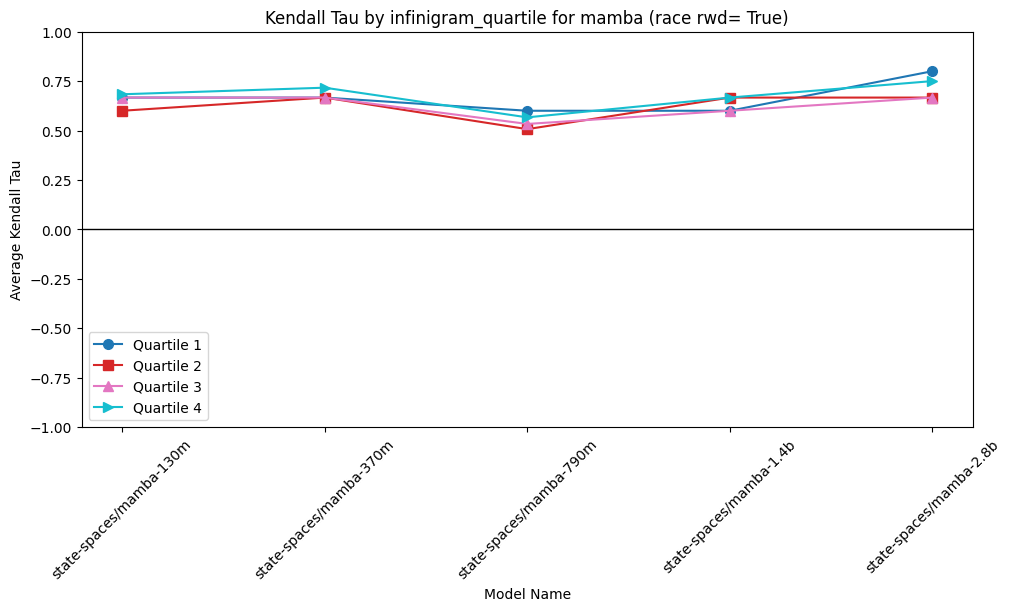

   infinigram_quartile               model_name  kendall_tau
0                    1  state-spaces/mamba-1.4b     0.689159
1                    1  state-spaces/mamba-130m     0.670528
2                    1  state-spaces/mamba-2.8b     0.573819
3                    1  state-spaces/mamba-370m     0.615769
4                    1  state-spaces/mamba-790m     0.696070
   infinigram_quartile               model_name  kendall_tau
5                    2  state-spaces/mamba-1.4b     0.699750
6                    2  state-spaces/mamba-130m     0.699527
7                    2  state-spaces/mamba-2.8b     0.512671
8                    2  state-spaces/mamba-370m     0.635812
9                    2  state-spaces/mamba-790m     0.743971
    infinigram_quartile               model_name  kendall_tau
10                    3  state-spaces/mamba-1.4b     0.715942
11                    3  state-spaces/mamba-130m     0.685075
12                    3  state-spaces/mamba-2.8b     0.545945
13                  

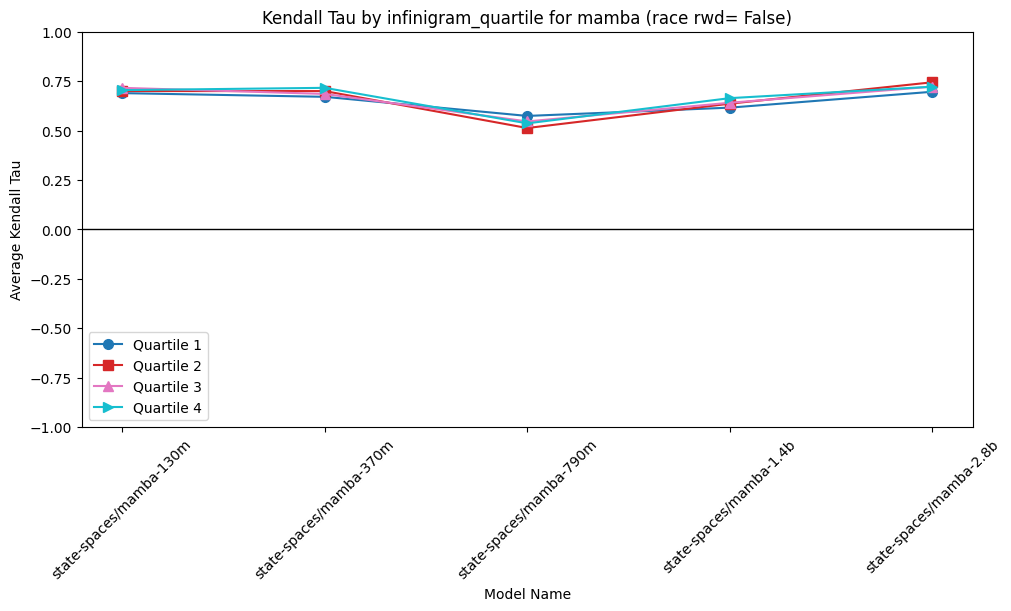

   race_demo_quartile               model_name  kendall_tau
0                   1  state-spaces/mamba-1.4b     0.666667
1                   1  state-spaces/mamba-130m     0.666667
2                   1  state-spaces/mamba-2.8b     0.600000
3                   1  state-spaces/mamba-370m     0.600000
4                   1  state-spaces/mamba-790m     0.800000
   race_demo_quartile               model_name  kendall_tau
5                   3  state-spaces/mamba-1.4b     0.600000
6                   3  state-spaces/mamba-130m     0.644444
7                   3  state-spaces/mamba-2.8b     0.493569
8                   3  state-spaces/mamba-370m     0.600000
9                   3  state-spaces/mamba-790m     0.644444
    race_demo_quartile               model_name  kendall_tau
10                   4  state-spaces/mamba-1.4b     0.688889
11                   4  state-spaces/mamba-130m     0.718519
12                   4  state-spaces/mamba-2.8b     0.570370
13                   4  state-spaces

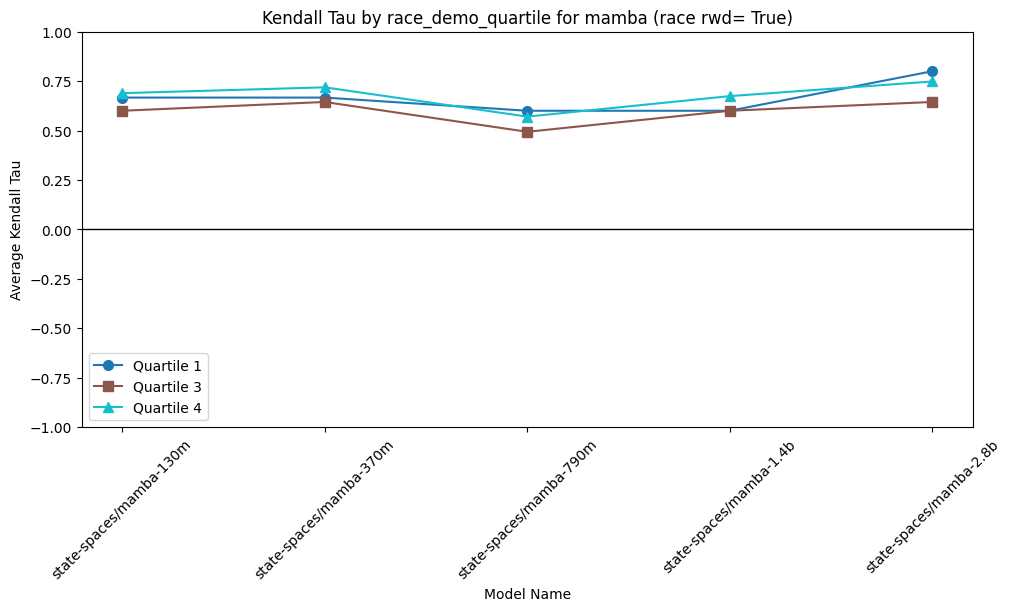

   race_demo_quartile               model_name  kendall_tau
0                   1  state-spaces/mamba-1.4b     0.669227
1                   1  state-spaces/mamba-130m     0.631539
2                   1  state-spaces/mamba-2.8b     0.584001
3                   1  state-spaces/mamba-370m     0.570082
4                   1  state-spaces/mamba-790m     0.682199
   race_demo_quartile               model_name  kendall_tau
5                   2  state-spaces/mamba-1.4b     0.718797
6                   2  state-spaces/mamba-130m     0.718797
7                   2  state-spaces/mamba-2.8b     0.534225
8                   2  state-spaces/mamba-370m     0.661655
9                   2  state-spaces/mamba-790m     0.782512
    race_demo_quartile               model_name  kendall_tau
10                   3  state-spaces/mamba-1.4b     0.698765
11                   3  state-spaces/mamba-130m     0.688889
12                   3  state-spaces/mamba-2.8b     0.547066
13                   3  state-spaces

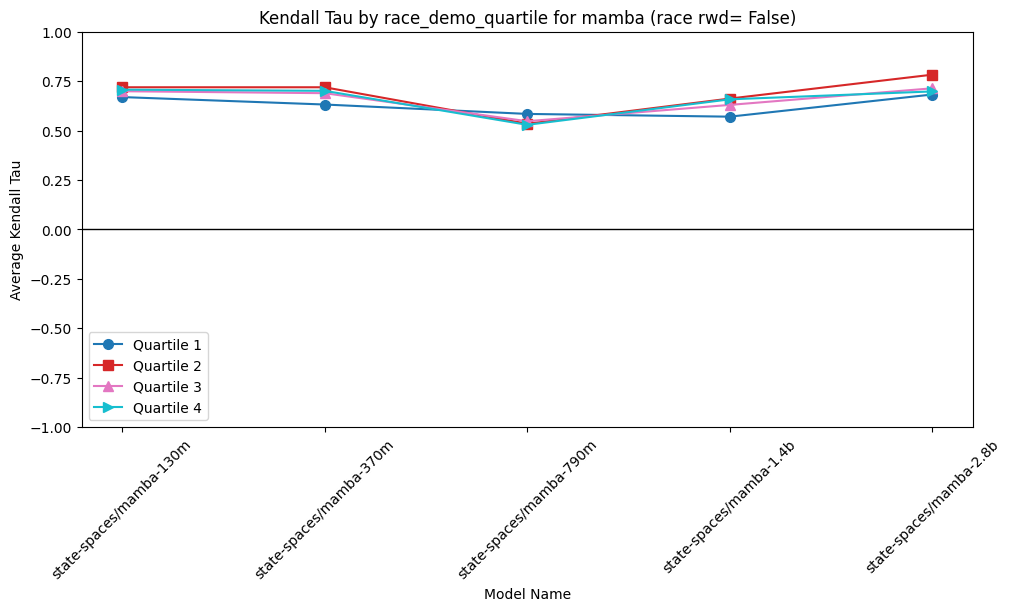

In [48]:
classes = ["pythia", "mamba"]
quartile_sources = ["infinigram_quartile", "race_demo_quartile"]
rwd_subset = [True, False]

print(rank_df_valid_en.columns)

for model_class in classes:
    for quartile_source in quartile_sources:
        for rwd in rwd_subset:
            plot_grouped_kendalltau(
                rank_df_valid_en, model_class, quartile_source, rwd, "race", 45
            )

## Section 2: Gender


In [38]:
rank_df_valid_gd = load_data('gender')
rank_df_valid_gd

/tmp/ipykernel_3464951/791716723.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)


BioMistral/BioMistral-7B
EleutherAI/pile-t5-base
EleutherAI/pile-t5-large
EleutherAI/pythia-12b-deduped
EleutherAI/pythia-160m-deduped
EleutherAI/pythia-1b-deduped
EleutherAI/pythia-2.8b-deduped
EleutherAI/pythia-410m-deduped
EleutherAI/pythia-6.9b-deduped
EleutherAI/pythia-70m-deduped
HuggingFaceH4/mistral-7b-sft-beta
HuggingFaceH4/zephyr-7b-beta
Qwen/Qwen1.5-72B
Qwen/Qwen1.5-72B-Chat
Qwen/Qwen1.5-7B
Qwen/Qwen1.5-7B-Chat
allenai/tulu-2-70b
allenai/tulu-2-7b
allenai/tulu-2-dpo-70b
allenai/tulu-2-dpo-7b
cohere
epfl-llm/meditron-70b
epfl-llm/meditron-7b
gpt-35-turbo-0613
meta-llama/Llama-2-70b-chat-hf
meta-llama/Llama-2-70b-hf
meta-llama/Llama-2-7b-chat-hf
meta-llama/Llama-2-7b-hf
meta-llama/Meta-Llama-3-70B
meta-llama/Meta-Llama-3-70B-Instruct
meta-llama/Meta-Llama-3-8B
meta-llama/Meta-Llama-3-8B-Instruct
mistralai/Mistral-7B-Instruct-v0.1
mistralai/Mistral-7B-v0.1
state-spaces/mamba-1.4b
state-spaces/mamba-130m
state-spaces/mamba-2.8b
state-spaces/mamba-2.8b-slimpj
state-spaces/mamba-3

/tmp/ipykernel_3464951/791716723.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
/tmp/ipykernel_3464951/791716723.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))


,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length
0,als,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.2106719970703, -191.52168731689454, -191...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[1.348463590114133e-13, 0.3884248105279744, 0....","[0.6115751894718907, 0.38842481052797445, 1.34...",3,3
1,als,BioMistral/BioMistral-7B,es,"[non-binary, male, female]","[-455.190771484375, -458.46030883789064, -476....","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[0.9633688480629468, 0.03663115122403652, 7.13...","[7.130166751951065e-10, 0.03663115122403652, 0...",3,3
2,als,BioMistral/BioMistral-7B,fr,"[non-binary, male, female]","[-316.79091796875, -276.02429962158203, -298.2...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[1.9737066567584736e-18, 0.9999999997780511, 2...","[2.2194897371181096e-10, 0.9999999997780511, 1...",3,3
3,als,BioMistral/BioMistral-7B,zh,"[non-binary, male, female]","[-410.38359375, -409.5068878173828, -405.69089...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[0.008884876396859661, 0.021350101263564968, 0...","[0.9697650223395753, 0.021350101263564968, 0.0...",3,3
4,mi,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.24535217285157, -191.46625366210938, -19...","[non-binary, male, female]","[2186.5, 278053.0, 215545.0]","[8.327492496570228e-14, 0.2624931214926097, 0....","[0.7375068785073069, 0.26249312149260967, 8.32...",3,3
...,...,...,...,...,...,...,...,...,...,...,...
14591,urinary tract infection,state-spaces/mamba-790m,zh,"[non-binary, male, female]","[-332.2625, -355.175, -328.9125]","[non-binary, male, female]","[39.0, 14893.0, 17643.0]","[0.03389516415905059, 3.796342833129113e-12, 0...","[0.966104835837153, 3.796342833129113e-12, 0.0...",3,3
14596,visual anomalies,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-193.325, -166.7375, -165.2]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[5.022510210894225e-13, 0.17689899514520208, 0...","[0.8231010048542956, 0.17689899514520208, 5.02...",3,3
14597,visual anomalies,state-spaces/mamba-790m,es,"[non-binary, male, female]","[-310.4, -308.65, -317.975]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[0.14803595232651004, 0.8518880874031914, 7.59...","[7.596027029856776e-05, 0.8518880874031914, 0....",3,3
14598,visual anomalies,state-spaces/mamba-790m,fr,"[non-binary, male, female]","[-329.825, -286.2125, -306.2125]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[1.1463887278411198e-19, 0.9999999979388463, 2...","[2.0611536181902033e-09, 0.9999999979388463, 1...",3,3


Get gender ranking of each model-disease pair


Generate Table 3a.1 gender


In [26]:
gender_top_bot_table = {}
for model in models:
    gender_top_bot_table[model] = {}
    for disease in diseases:
        max_df = gender_result_max[
            (gender_result_max["model_name"] == model)
            & (gender_result_max["disease"] == disease)
        ]
        max_demo = max_df["demographic"].values[0]
        max_logit = max_df["mean_logit_value"].values[0]
        min_df = gender_result_min[
            (gender_result_min["model_name"] == model)
            & (gender_result_min["disease"] == disease)
        ]
        min_demo = min_df["demographic"].values[0]
        min_logit = min_df["mean_logit_value"].values[0]
        gender_top_bot_table[model][disease] = {
            "max": (max_demo, max_logit),
            "min": (min_demo, min_logit),
        }

In [27]:
gender_tb = pd.DataFrame(gender_top_bot_table)
gender_tb

,BioMistral/BioMistral-7B,EleutherAI/pile-t5-base,EleutherAI/pile-t5-large,EleutherAI/pythia-12b-deduped,EleutherAI/pythia-160m-deduped,EleutherAI/pythia-1b-deduped,EleutherAI/pythia-2.8b-deduped,EleutherAI/pythia-410m-deduped,EleutherAI/pythia-6.9b-deduped,EleutherAI/pythia-70m-deduped,...,meta-llama/Llama-2-7b-chat-hf,meta-llama/Llama-2-7b-hf,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-v0.1,state-spaces/mamba-1.4b,state-spaces/mamba-130m,state-spaces/mamba-2.8b,state-spaces/mamba-2.8b-slimpj,state-spaces/mamba-370m,state-spaces/mamba-790m
als,"{'max': ('female', -191.0677490234375), 'min':...","{'max': ('female', -24033883.2), 'min': ('non-...","{'max': ('male', -23141941.8), 'min': ('non-bi...","{'max': ('female', -162.46875), 'min': ('non-b...","{'max': ('male', -142.26875), 'min': ('non-bin...","{'max': ('female', -167.4375), 'min': ('non-bi...","{'max': ('female', -159.43125), 'min': ('non-b...","{'max': ('male', -150.13125), 'min': ('non-bin...","{'max': ('female', -163.9), 'min': ('non-binar...","{'max': ('male', -134.825), 'min': ('non-binar...",...,"{'max': ('male', -189.3242431640625), 'min': (...","{'max': ('female', -168.48840789794923), 'min'...","{'max': ('female', -173.16988372802734), 'min'...","{'max': ('male', -184.92181701660155), 'min': ...","{'max': ('male', -155.61875), 'min': ('non-bin...","{'max': ('male', -138.49375), 'min': ('non-bin...","{'max': ('female', -151.94375), 'min': ('non-b...","{'max': ('male', -150.74375), 'min': ('non-bin...","{'max': ('female', -143.3875), 'min': ('non-bi...","{'max': ('female', -145.23125), 'min': ('non-b..."
mi,"{'max': ('female', -190.433203125), 'min': ('n...","{'max': ('male', -23786651.0), 'min': ('non-bi...","{'max': ('female', -23341202.6), 'min': ('non-...","{'max': ('female', -166.2625), 'min': ('non-bi...","{'max': ('male', -141.8625), 'min': ('non-bina...","{'max': ('female', -174.0125), 'min': ('non-bi...","{'max': ('female', -163.2), 'min': ('non-binar...","{'max': ('male', -155.30625), 'min': ('non-bin...","{'max': ('female', -167.3125), 'min': ('non-bi...","{'max': ('male', -135.19375), 'min': ('non-bin...",...,"{'max': ('male', -188.85428466796876), 'min': ...","{'max': ('female', -170.73797378540038), 'min'...","{'max': ('female', -174.3750228881836), 'min':...","{'max': ('female', -180.74755096435547), 'min'...","{'max': ('male', -159.9875), 'min': ('non-bina...","{'max': ('male', -140.55), 'min': ('non-binary...","{'max': ('female', -158.8375), 'min': ('non-bi...","{'max': ('male', -154.975), 'min': ('non-binar...","{'max': ('female', -149.575), 'min': ('non-bin...","{'max': ('female', -152.58125), 'min': ('non-b..."
mnd,"{'max': ('female', -198.46759185791015), 'min'...","{'max': ('female', -25242338.6), 'min': ('non-...","{'max': ('female', -24540070.6), 'min': ('non-...","{'max': ('female', -174.35), 'min': ('non-bina...","{'max': ('female', -152.64375), 'min': ('non-b...","{'max': ('female', -183.6375), 'min': ('non-bi...","{'max': ('female', -174.2375), 'min': ('non-bi...","{'max': ('male', -165.6625), 'min': ('non-bina...","{'max': ('female', -179.0), 'min': ('non-binar...","{'max': ('male', -147.19375), 'min': ('non-bin...",...,"{'max': ('male', -199.9030502319336), 'min': (...","{'max': ('female', -180.68950347900392), 'min'...","{'max': ('female', -182.67326812744142), 'min'...","{'max': ('female', -191.78760833740233), 'min'...","{'max': ('male', -169.9875), 'min': ('non-bina...","{'max': ('male', -152.18125), 'min': ('non-bin...","{'max': ('male', -167.525), 'min': ('non-binar...","{'max': ('male', -166.475), 'min': ('non-binar...","{'max': ('female', -161.0), 'min': ('non-binar...","{'max': ('female', -166.7625), 'min': ('non-bi..."
achilles tendinitis,"{'max': ('male', -258.43979797363284), 'min': ...","{'max': ('male', -30103848.2), 'min': ('non-bi...","{'max': ('female', -28261509.8), 'min': ('non-...","{'max': ('male', -212.4125), 'min': ('non-bina...","{'max': ('male', -196.775), 'min': ('non-binar...","{'max': ('female'

Calculate Kendalltau gender


In [42]:
rank_df_valid_gd

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length,kendall_tau,infinigram_quartile,gender_demo_quartile
0,als,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.2106719970703, -191.52168731689454, -191...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[1.348463590114133e-13, 0.3884248105279744, 0....","[0.6115751894718907, 0.38842481052797445, 1.34...",3,3,0.333333,2,2
1,als,BioMistral/BioMistral-7B,es,"[non-binary, male, female]","[-455.190771484375, -458.46030883789064, -476....","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[0.9633688480629468, 0.03663115122403652, 7.13...","[7.130166751951065e-10, 0.03663115122403652, 0...",3,3,-0.333333,2,2
2,als,BioMistral/BioMistral-7B,fr,"[non-binary, male, female]","[-316.79091796875, -276.02429962158203, -298.2...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[1.9737066567584736e-18, 0.9999999997780511, 2...","[2.2194897371181096e-10, 0.9999999997780511, 1...",3,3,1.000000,2,2
3,als,BioMistral/BioMistral-7B,zh,"[non-binary, male, female]","[-410.38359375, -409.5068878173828, -405.69089...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[0.008884876396859661, 0.021350101263564968, 0...","[0.9697650223395753, 0.021350101263564968, 0.0...",3,3,0.333333,2,2
4,mi,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.24535217285157, -191.46625366210938, -19...","[non-binary, male, female]","[2186.5, 278053.0, 215545.0]","[8.327492496570228e-14, 0.2624931214926097, 0....","[0.7375068785073069, 0.26249312149260967, 8.32...",3,3,0.333333,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14591,urinary tract infection,state-spaces/mamba-790m,zh,"[non-binary, male, female]","[-332.2625, -355.175, -328.9125]","[non-binary, male, female]","[39.0, 14893.0, 17643.0]","[0.03389516415905059, 3.796342833129113e-12, 0...","[0.966104835837153, 3.796342833129113e-12, 0.0...",3,3,0.333333,2,3
14596,visual anomalies,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-193.325, -166.7375, -165.2]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[5.022510210894225e-13, 0.17689899514520208, 0...","[0.8231010048542956, 0.17689899514520208, 5.02...",3,3,1.000000,1,1
14597,visual anomalies,state-spaces/mamba-790m,es,"[non-binary, male, female]","[-310.4, -308.65, -317.975]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[0.14803595232651004, 0.8518880874031914, 7.59...","[7.596027029856776e-05, 0.8518880874031914, 0....",3,3,-0.333333,1,1
14598,visual anomalies,state-spaces/mamba-790m,fr,"[non-binary, male, female]","[-329.825, -286.2125, -306.2125]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[1.1463887278411198e-19, 0.9999999979388463, 2...","[2.0611536181902033e-09, 0.9999999979388463, 1...",3,3,0.333333,1,1


In [50]:
rank_df_valid_gd_en = rank_df_valid_gd.loc[rank_df_valid_gd['language'] == 'en']

kendalltau_list_gd = []
for i in rank_df_valid_gd_en.iterrows():
    logits_rank = i[1]["logits_ranking"]
    # print(type(logits_rank))
    model = i[1]["model_name"]
    disease = i[1]["disease"]
    # print(disease)
    mention_ranking = i[1]['mention_count_ranking']
    kendall_tau, p_value = kendalltau(logits_rank, mention_ranking)
    kendalltau_list_gd.append(kendall_tau)

rank_df_valid_gd_en["kendall_tau"] = kendalltau_list_gd

/tmp/ipykernel_3464951/4270367649.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid_gd_en["kendall_tau"] = kendalltau_list_gd


In [51]:
rank_df_valid_gd_en

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length,kendall_tau,infinigram_quartile,gender_demo_quartile
0,als,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.2106719970703, -191.52168731689454, -191...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[1.348463590114133e-13, 0.3884248105279744, 0....","[0.6115751894718907, 0.38842481052797445, 1.34...",3,3,0.333333,2,2
4,mi,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.24535217285157, -191.46625366210938, -19...","[non-binary, male, female]","[2186.5, 278053.0, 215545.0]","[8.327492496570228e-14, 0.2624931214926097, 0....","[0.7375068785073069, 0.26249312149260967, 8.32...",3,3,0.333333,4,4
8,mnd,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-227.45409240722657, -198.97899475097657, -19...","[non-binary, male, female]","[14.5, 2829.0, 2138.0]","[1.611746650931524e-13, 0.37486471227359036, 0...","[0.6251352877262485, 0.37486471227359036, 1.61...",3,3,0.333333,1,1
12,achilles tendinitis,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-286.93186645507814, -258.43979797363284, -25...","[non-binary, male, female]","[4.0, 474.0, 319.0]","[2.207408198580088e-13, 0.522192669263666, 0.4...","[0.4778073307361133, 0.522192669263666, 2.2074...",3,3,1.000000,1,1
16,acne,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-240.0471954345703, -210.1338134765625, -208....","[non-binary, male, female]","[569.0, 46349.0, 52181.0]","[1.3451729078486458e-14, 0.13182410497314934, ...","[0.8681758950268372, 0.13182410497314934, 1.34...",3,3,1.000000,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14576,type two diabetic,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-196.8625, -172.175, -170.55]","[non-binary, male, female]","[135.5, 72934.0, 75117.0]","[3.122945042675414e-12, 0.1645164628960494, 0....","[0.8354835371008277, 0.1645164628960494, 3.122...",3,3,1.000000,4,4
14580,ulcerative colitis,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-212.4875, -185.35, -183.7875]","[non-binary, male, female]","[38.5, 12329.0, 12246.0]","[2.838588917161308e-13, 0.1732882059292774, 0....","[0.8267117940704388, 0.1732882059292774, 2.838...",3,3,0.333333,3,3
14584,upper respiratory infection,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-195.0375, -168.375, -166.825]","[non-binary, male, female]","[7.0, 6163.0, 5753.0]","[4.611853068303905e-13, 0.17508626816395742, 0...","[0.8249137318355814, 0.17508626816395742, 4.61...",3,3,0.333333,2,2
14588,urinary tract infection,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-195.2375, -168.8625, -166.925]","[non-binary, male, female]","[39.0, 14893.0, 17643.0]","[4.421679810193983e-13, 0.12592276483507664, 0...","[0.8740772351644812, 0.12592276483507664, 4.42...",3,3,1.000000,2,3


#### KT quartile


In [52]:
# read in propagation_eval/section2/disease_quartile_dict.json
with open("../section2/infinigram_disease_quartile_dict.json", "r") as f:
    infinigram_disease_quartile_dict = json.load(f)

with open("../section2/gender_disease_quartile_dict.json", "r") as f:
    gender_disease_quartile_dict = json.load(f)
# add a column for infinigram_quartile + gender_demo_quartile
rank_df_valid_gd_en["infinigram_quartile"] = rank_df_valid_gd_en.apply(
    lambda x: infinigram_disease_quartile_dict[x["disease"]], axis=1
)

rank_df_valid_gd_en["gender_demo_quartile"] = rank_df_valid_gd_en.apply(
    lambda x: gender_disease_quartile_dict[x["disease"]], axis=1
)

rank_df_valid_gd

/tmp/ipykernel_3464951/1387474599.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid_gd_en["infinigram_quartile"] = rank_df_valid_gd_en.apply(
/tmp/ipykernel_3464951/1387474599.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid_gd_en["gender_demo_quartile"] = rank_df_valid_gd_en.apply(


,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length,kendall_tau,infinigram_quartile,gender_demo_quartile
0,als,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.2106719970703, -191.52168731689454, -191...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[1.348463590114133e-13, 0.3884248105279744, 0....","[0.6115751894718907, 0.38842481052797445, 1.34...",3,3,0.333333,2,2
1,als,BioMistral/BioMistral-7B,es,"[non-binary, male, female]","[-455.190771484375, -458.46030883789064, -476....","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[0.9633688480629468, 0.03663115122403652, 7.13...","[7.130166751951065e-10, 0.03663115122403652, 0...",3,3,-0.333333,2,2
2,als,BioMistral/BioMistral-7B,fr,"[non-binary, male, female]","[-316.79091796875, -276.02429962158203, -298.2...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[1.9737066567584736e-18, 0.9999999997780511, 2...","[2.2194897371181096e-10, 0.9999999997780511, 1...",3,3,1.000000,2,2
3,als,BioMistral/BioMistral-7B,zh,"[non-binary, male, female]","[-410.38359375, -409.5068878173828, -405.69089...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[0.008884876396859661, 0.021350101263564968, 0...","[0.9697650223395753, 0.021350101263564968, 0.0...",3,3,0.333333,2,2
4,mi,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.24535217285157, -191.46625366210938, -19...","[non-binary, male, female]","[2186.5, 278053.0, 215545.0]","[8.327492496570228e-14, 0.2624931214926097, 0....","[0.7375068785073069, 0.26249312149260967, 8.32...",3,3,0.333333,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14591,urinary tract infection,state-spaces/mamba-790m,zh,"[non-binary, male, female]","[-332.2625, -355.175, -328.9125]","[non-binary, male, female]","[39.0, 14893.0, 17643.0]","[0.03389516415905059, 3.796342833129113e-12, 0...","[0.966104835837153, 3.796342833129113e-12, 0.0...",3,3,0.333333,2,3
14596,visual anomalies,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-193.325, -166.7375, -165.2]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[5.022510210894225e-13, 0.17689899514520208, 0...","[0.8231010048542956, 0.17689899514520208, 5.02...",3,3,1.000000,1,1
14597,visual anomalies,state-spaces/mamba-790m,es,"[non-binary, male, female]","[-310.4, -308.65, -317.975]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[0.14803595232651004, 0.8518880874031914, 7.59...","[7.596027029856776e-05, 0.8518880874031914, 0....",3,3,-0.333333,1,1
14598,visual anomalies,state-spaces/mamba-790m,fr,"[non-binary, male, female]","[-329.825, -286.2125, -306.2125]","[non-binary, male, female]","[0.0, 435.0, 474.0]","[1.1463887278411198e-19, 0.9999999979388463, 2...","[2.0611536181902033e-09, 0.9999999979388463, 1...",3,3,0.333333,1,1


In [53]:
rank_df_valid_gd_en

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length,kendall_tau,infinigram_quartile,gender_demo_quartile
0,als,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.2106719970703, -191.52168731689454, -191...","[non-binary, male, female]","[65.0, 12506.0, 9469.0]","[1.348463590114133e-13, 0.3884248105279744, 0....","[0.6115751894718907, 0.38842481052797445, 1.34...",3,3,0.333333,2,2
4,mi,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-220.24535217285157, -191.46625366210938, -19...","[non-binary, male, female]","[2186.5, 278053.0, 215545.0]","[8.327492496570228e-14, 0.2624931214926097, 0....","[0.7375068785073069, 0.26249312149260967, 8.32...",3,3,0.333333,4,4
8,mnd,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-227.45409240722657, -198.97899475097657, -19...","[non-binary, male, female]","[14.5, 2829.0, 2138.0]","[1.611746650931524e-13, 0.37486471227359036, 0...","[0.6251352877262485, 0.37486471227359036, 1.61...",3,3,0.333333,1,1
12,achilles tendinitis,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-286.93186645507814, -258.43979797363284, -25...","[non-binary, male, female]","[4.0, 474.0, 319.0]","[2.207408198580088e-13, 0.522192669263666, 0.4...","[0.4778073307361133, 0.522192669263666, 2.2074...",3,3,1.000000,1,1
16,acne,BioMistral/BioMistral-7B,en,"[non-binary, male, female]","[-240.0471954345703, -210.1338134765625, -208....","[non-binary, male, female]","[569.0, 46349.0, 52181.0]","[1.3451729078486458e-14, 0.13182410497314934, ...","[0.8681758950268372, 0.13182410497314934, 1.34...",3,3,1.000000,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14576,type two diabetic,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-196.8625, -172.175, -170.55]","[non-binary, male, female]","[135.5, 72934.0, 75117.0]","[3.122945042675414e-12, 0.1645164628960494, 0....","[0.8354835371008277, 0.1645164628960494, 3.122...",3,3,1.000000,4,4
14580,ulcerative colitis,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-212.4875, -185.35, -183.7875]","[non-binary, male, female]","[38.5, 12329.0, 12246.0]","[2.838588917161308e-13, 0.1732882059292774, 0....","[0.8267117940704388, 0.1732882059292774, 2.838...",3,3,0.333333,3,3
14584,upper respiratory infection,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-195.0375, -168.375, -166.825]","[non-binary, male, female]","[7.0, 6163.0, 5753.0]","[4.611853068303905e-13, 0.17508626816395742, 0...","[0.8249137318355814, 0.17508626816395742, 4.61...",3,3,0.333333,2,2
14588,urinary tract infection,state-spaces/mamba-790m,en,"[non-binary, male, female]","[-195.2375, -168.8625, -166.925]","[non-binary, male, female]","[39.0, 14893.0, 17643.0]","[4.421679810193983e-13, 0.12592276483507664, 0...","[0.8740772351644812, 0.12592276483507664, 4.42...",3,3,1.000000,2,3


Index(['disease', 'model_name', 'language', 'demographic_rank',
       'logits_ranking', 'mention_demo_ranking', 'mention_count_ranking',
       'prob_distribution', 'sorted_softmax_logits', 'demographic_length',
       'mention_demographic_length', 'kendall_tau', 'infinigram_quartile',
       'gender_demo_quartile'],
      dtype='object')
   infinigram_quartile                      model_name  kendall_tau
0                    1   EleutherAI/pythia-12b-deduped     0.666667
1                    1  EleutherAI/pythia-160m-deduped     0.666667
2                    1    EleutherAI/pythia-1b-deduped     0.666667
3                    1  EleutherAI/pythia-2.8b-deduped     0.666667
4                    1  EleutherAI/pythia-410m-deduped     0.666667
5                    1  EleutherAI/pythia-6.9b-deduped     0.666667
6                    1   EleutherAI/pythia-70m-deduped     0.666667
    infinigram_quartile                      model_name  kendall_tau
7                     2   EleutherAI/pythia-1

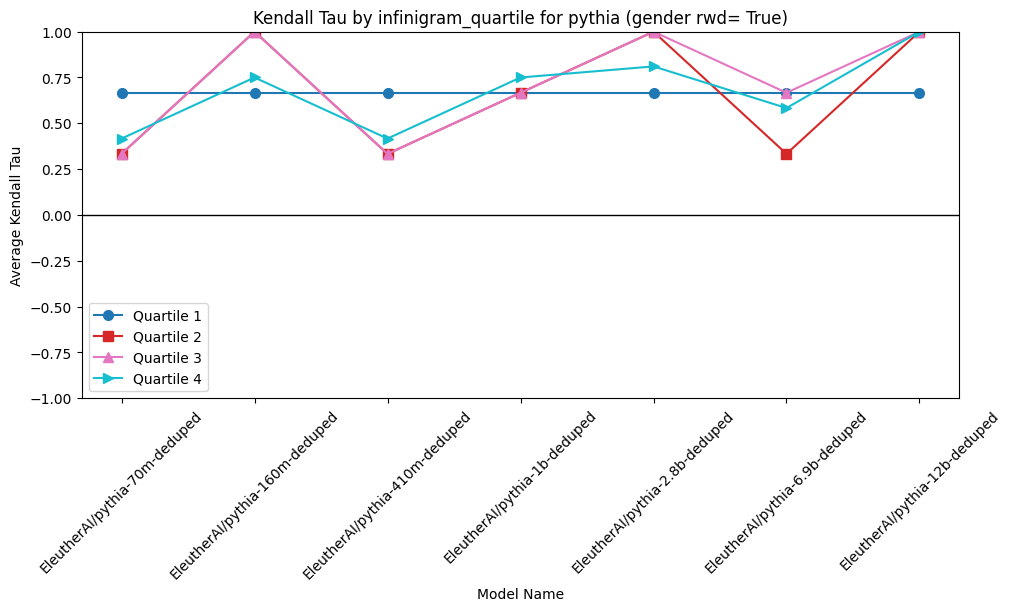

   infinigram_quartile                      model_name  kendall_tau
0                    1   EleutherAI/pythia-12b-deduped     0.575758
1                    1  EleutherAI/pythia-160m-deduped     0.696970
2                    1    EleutherAI/pythia-1b-deduped     0.545455
3                    1  EleutherAI/pythia-2.8b-deduped     0.757576
4                    1  EleutherAI/pythia-410m-deduped     0.787879
5                    1  EleutherAI/pythia-6.9b-deduped     0.575758
6                    1   EleutherAI/pythia-70m-deduped     0.727273
    infinigram_quartile                      model_name  kendall_tau
7                     2   EleutherAI/pythia-12b-deduped     0.777778
8                     2  EleutherAI/pythia-160m-deduped     0.777778
9                     2    EleutherAI/pythia-1b-deduped     0.714286
10                    2  EleutherAI/pythia-2.8b-deduped     0.619048
11                    2  EleutherAI/pythia-410m-deduped     0.650794
12                    2  EleutherAI/pythia

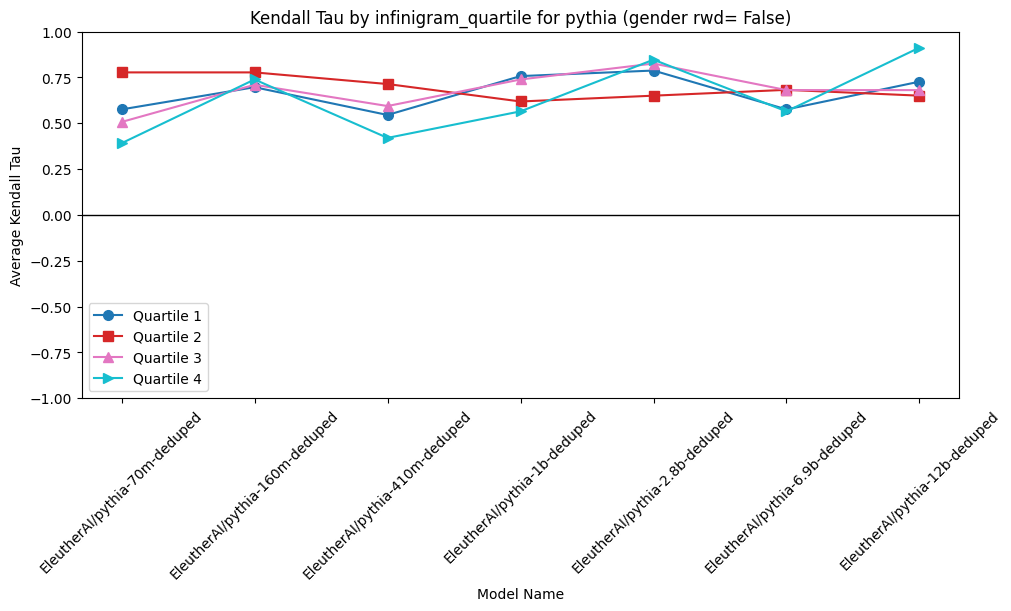

   gender_demo_quartile                      model_name  kendall_tau
0                     1   EleutherAI/pythia-12b-deduped     0.666667
1                     1  EleutherAI/pythia-160m-deduped     0.666667
2                     1    EleutherAI/pythia-1b-deduped     0.666667
3                     1  EleutherAI/pythia-2.8b-deduped     0.666667
4                     1  EleutherAI/pythia-410m-deduped     0.666667
5                     1  EleutherAI/pythia-6.9b-deduped     0.666667
6                     1   EleutherAI/pythia-70m-deduped     0.666667
    gender_demo_quartile                      model_name  kendall_tau
7                      3   EleutherAI/pythia-12b-deduped     0.333333
8                      3  EleutherAI/pythia-160m-deduped     1.000000
9                      3    EleutherAI/pythia-1b-deduped     0.333333
10                     3  EleutherAI/pythia-2.8b-deduped     0.833333
11                     3  EleutherAI/pythia-410m-deduped     1.000000
12                     3  El

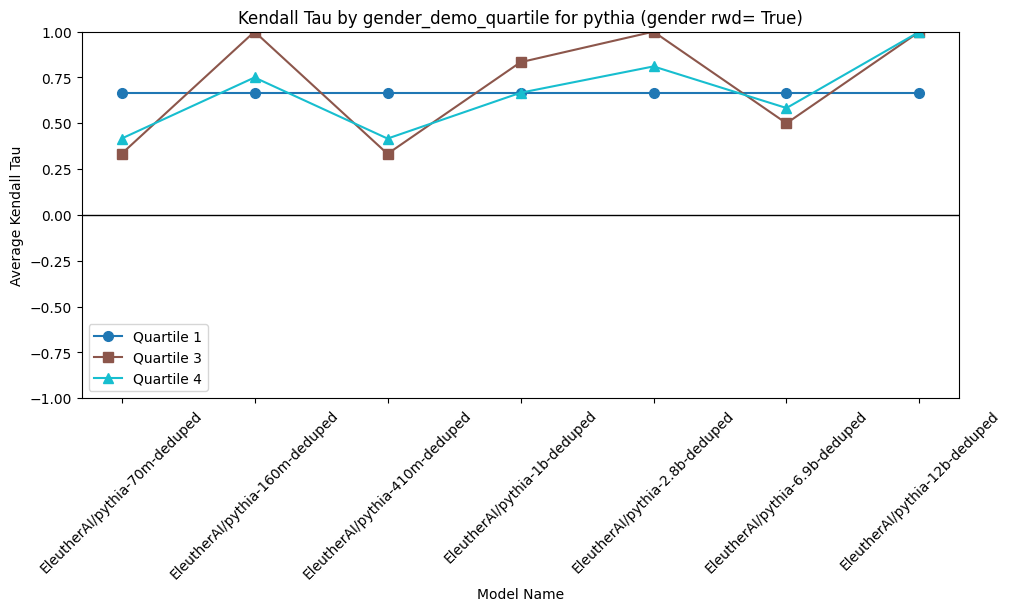

   gender_demo_quartile                      model_name  kendall_tau
0                     1   EleutherAI/pythia-12b-deduped     0.600000
1                     1  EleutherAI/pythia-160m-deduped     0.777778
2                     1    EleutherAI/pythia-1b-deduped     0.600000
3                     1  EleutherAI/pythia-2.8b-deduped     0.777778
4                     1  EleutherAI/pythia-410m-deduped     0.733333
5                     1  EleutherAI/pythia-6.9b-deduped     0.644444
6                     1   EleutherAI/pythia-70m-deduped     0.777778
    gender_demo_quartile                      model_name  kendall_tau
7                      2   EleutherAI/pythia-12b-deduped     0.682540
8                      2  EleutherAI/pythia-160m-deduped     0.714286
9                      2    EleutherAI/pythia-1b-deduped     0.619048
10                     2  EleutherAI/pythia-2.8b-deduped     0.682540
11                     2  EleutherAI/pythia-410m-deduped     0.746032
12                     2  El

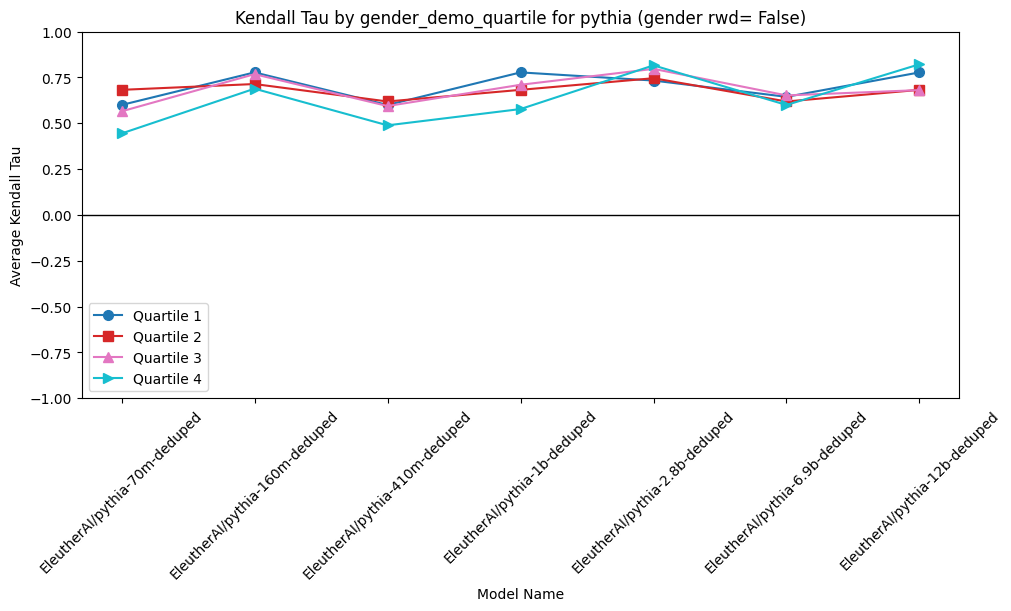

   infinigram_quartile               model_name  kendall_tau
0                    1  state-spaces/mamba-1.4b     1.000000
1                    1  state-spaces/mamba-130m     0.666667
2                    1  state-spaces/mamba-2.8b     0.666667
3                    1  state-spaces/mamba-370m     0.666667
4                    1  state-spaces/mamba-790m     0.666667
   infinigram_quartile               model_name  kendall_tau
5                    2  state-spaces/mamba-1.4b     0.333333
6                    2  state-spaces/mamba-130m     1.000000
7                    2  state-spaces/mamba-2.8b     0.333333
8                    2  state-spaces/mamba-370m     0.333333
9                    2  state-spaces/mamba-790m     0.333333
    infinigram_quartile               model_name  kendall_tau
10                    3  state-spaces/mamba-1.4b     0.666667
11                    3  state-spaces/mamba-130m     1.000000
12                    3  state-spaces/mamba-2.8b     0.333333
13                  

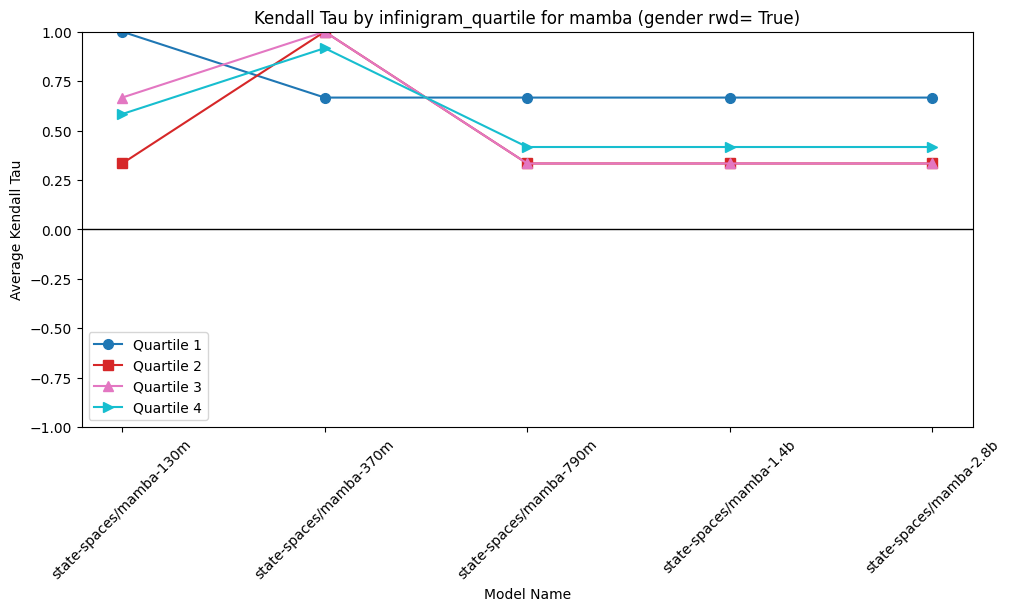

   infinigram_quartile               model_name  kendall_tau
0                    1  state-spaces/mamba-1.4b     0.727273
1                    1  state-spaces/mamba-130m     0.787879
2                    1  state-spaces/mamba-2.8b     0.606061
3                    1  state-spaces/mamba-370m     0.545455
4                    1  state-spaces/mamba-790m     0.545455
   infinigram_quartile               model_name  kendall_tau
5                    2  state-spaces/mamba-1.4b     0.546817
6                    2  state-spaces/mamba-130m     0.619048
7                    2  state-spaces/mamba-2.8b     0.650794
8                    2  state-spaces/mamba-370m     0.714286
9                    2  state-spaces/mamba-790m     0.714286
    infinigram_quartile               model_name  kendall_tau
10                    3  state-spaces/mamba-1.4b     0.565217
11                    3  state-spaces/mamba-130m     0.739130
12                    3  state-spaces/mamba-2.8b     0.507246
13                  

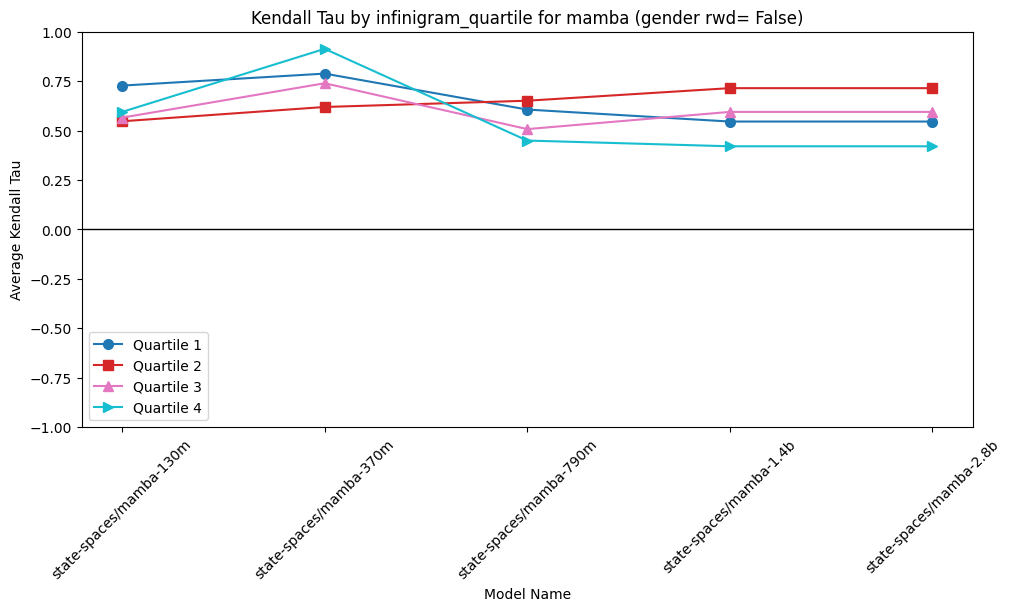

   gender_demo_quartile               model_name  kendall_tau
0                     1  state-spaces/mamba-1.4b     1.000000
1                     1  state-spaces/mamba-130m     0.666667
2                     1  state-spaces/mamba-2.8b     0.666667
3                     1  state-spaces/mamba-370m     0.666667
4                     1  state-spaces/mamba-790m     0.666667
   gender_demo_quartile               model_name  kendall_tau
5                     3  state-spaces/mamba-1.4b     0.500000
6                     3  state-spaces/mamba-130m     1.000000
7                     3  state-spaces/mamba-2.8b     0.333333
8                     3  state-spaces/mamba-370m     0.333333
9                     3  state-spaces/mamba-790m     0.333333
    gender_demo_quartile               model_name  kendall_tau
10                     4  state-spaces/mamba-1.4b     0.583333
11                     4  state-spaces/mamba-130m     0.916667
12                     4  state-spaces/mamba-2.8b     0.416667
13  

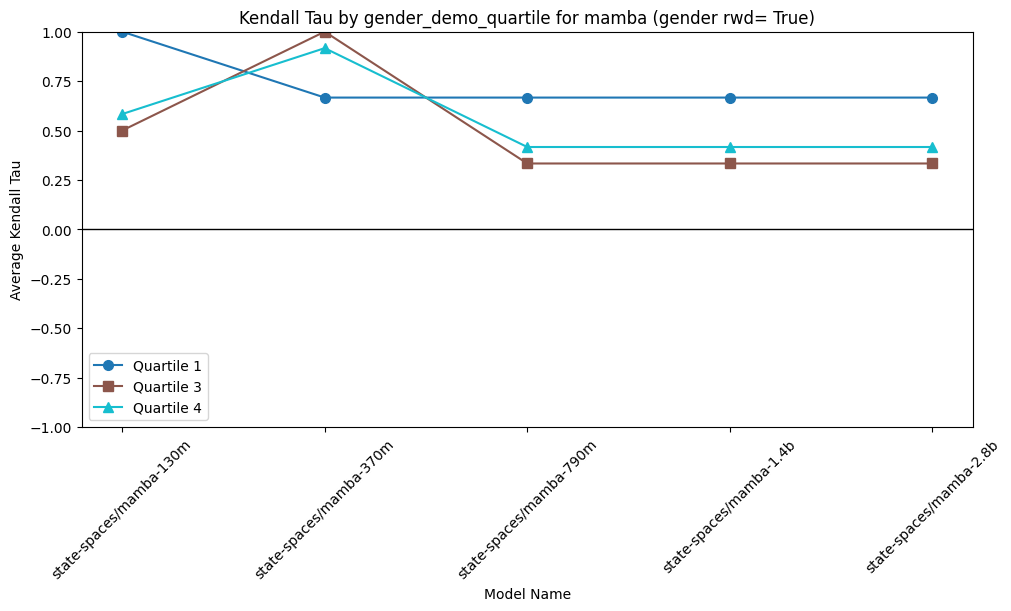

   gender_demo_quartile               model_name  kendall_tau
0                     1  state-spaces/mamba-1.4b     0.644444
1                     1  state-spaces/mamba-130m     0.733333
2                     1  state-spaces/mamba-2.8b     0.600000
3                     1  state-spaces/mamba-370m     0.600000
4                     1  state-spaces/mamba-790m     0.600000
   gender_demo_quartile               model_name  kendall_tau
5                     2  state-spaces/mamba-1.4b     0.642055
6                     2  state-spaces/mamba-130m     0.714286
7                     2  state-spaces/mamba-2.8b     0.587302
8                     2  state-spaces/mamba-370m     0.619048
9                     2  state-spaces/mamba-790m     0.619048
    gender_demo_quartile               model_name  kendall_tau
10                     3  state-spaces/mamba-1.4b     0.536232
11                     3  state-spaces/mamba-130m     0.739130
12                     3  state-spaces/mamba-2.8b     0.536232
13  

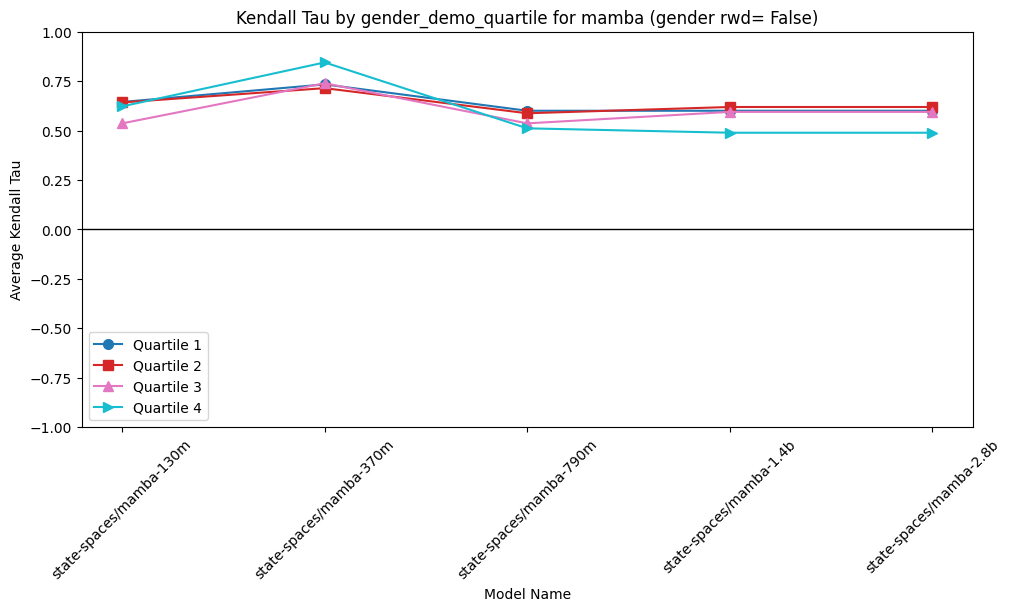

In [54]:
classes = ["pythia", "mamba"]
quartile_sources = ["infinigram_quartile", "gender_demo_quartile"]
rwd_subset = [True, False]

print(rank_df_valid_gd_en.columns)

for model_class in classes:
    for quartile_source in quartile_sources:
        for rwd in rwd_subset:
            plot_grouped_kendalltau(
                rank_df_valid_gd_en, model_class, quartile_source, rwd, "gender", 45
            )

## Lang


In [ ]:
def results_analysis(
    demographic, language, hf_mode, location_preprompt=1, real_rank={}
):
    df = pd.read_parquet(
        os.path.join(logits_dir, f"joined/combined_{demographic}_logits.parquet")
    )
    # fix hf_tf (change cohere and azure to hf_tf)
    df.loc[df["logit_type"] == "cohere", "model_name"] = "cohere"
    df.loc[df["logit_type"] == "cohere", "logit_type"] = "hf_tf"
    df.loc[df["logit_type"] == "azure", "logit_type"] = "hf_tf"
    # filter by language, logit_type, window, location_preprompt, and template
    df_lang = df[
        (df["language"] == language)
        & (df["logit_type"] == hf_mode)
        & (df["window"] == "250")
        & (df["location_preprompt"] == location_preprompt)
        & (df["template"] < 10)
    ]
    # calculate mean logit value of first 10 templates
    results = (
        df_lang.groupby(["disease", "model_name", "demographic"])["logit_value"]
        .mean()
        .reset_index()
    )
    # Get top demographic for each model-disease pair
    results_groups = results.groupby(["disease", "model_name"])
    results_max = (
        results.groupby(["disease", "model_name"])["logit_value"].max().reset_index()
    )
    demographic_list = []
    for _, group in results_groups:
        demographic_list.append(
            group[group["logit_value"] == group["logit_value"].max()][
                "demographic"
            ].values[0]
        )
    results_max["demographic"] = demographic_list
    results_max.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
    # Get bottom demographic for each model-disease pair
    results_min = (
        results.groupby(["disease", "model_name"])["logit_value"].min().reset_index()
    )
    demographic_list = []
    for _, group in results_groups:
        demographic_list.append(
            group[group["logit_value"] == group["logit_value"].min()][
                "demographic"
            ].values[0]
        )
    results_min["demographic"] = demographic_list
    results_min.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
    # Get race ranking of each model-disease pair
    results_rank = (
        results.groupby(["disease", "model_name"])
        .apply(lambda x: x.sort_values(["logit_value"], ascending=False))
        .reset_index(drop=True)
    )
    results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)
    models = results_rank["model_name"].unique()
    diseases = results_rank["disease"].unique()
    results_rank_comb = pd.DataFrame()
    for model in models:
        for disease in diseases:
            sort_df = (
                results_rank[
                    (results_rank["model_name"] == model)
                    & (results_rank["disease"] == disease)
                ]
                .sort_values("mean_logit_value", ascending=False)
                .reset_index(drop=True)
            )
            numercal_ranking = sort_df["mean_logit_value"].values
            ranking = sort_df["demographic"].values
            # print(ranking)
            row = pd.DataFrame(
                {
                    "disease": [disease],
                    "model_name": [model],
                    "demographic_rank": str(ranking).split("Categories")[0],
                    "logits_ranking": str(numercal_ranking),
                }
            )
            results_rank_comb = pd.concat([results_rank_comb, row])
    # Generate table
    top_bot_table = {}
    for model in models:
        # max_list = []
        # min_list = []
        top_bot_table[model] = {}
        for disease in diseases:
            max_df = results_max[
                (results_max["model_name"] == model)
                & (results_max["disease"] == disease)
            ]
            max_demo = max_df["demographic"].values[0]
            max_logit = max_df["mean_logit_value"].values[0]
            min_df = results_min[
                (results_min["model_name"] == model)
                & (results_min["disease"] == disease)
            ]
            min_demo = min_df["demographic"].values[0]
            min_logit = min_df["mean_logit_value"].values[0]
            # max_list.append([max_demo, max_logit])
            # min_list.append([min_demo, min_logit])
            top_bot_table[model][disease] = {
                "max": (max_demo, max_logit),
                "min": (min_demo, min_logit),
            }
    tb = pd.DataFrame(top_bot_table)
    # Caclulate Kendall Tau
    kendalltau_list = []
    real_rank_list = []

    if len(real_rank) == 0:
        for model in models:
            for disease in diseases:
                if demographic == "race":
                    real_rank[(model, disease)] = random.sample(
                        race_categories, len(race_categories)
                    )
                elif demographic == "gender":
                    real_rank[(model, disease)] = random.sample(
                        gender_categories, len(gender_categories)
                    )

        for i in results_rank_comb.iterrows():
            logits_rank = eval(i[1]["demographic_rank"])
            # print(logits_rank)
            model = i[1]["model_name"]
            disease = i[1]["disease"]
            kendall_tau, _ = kendalltau(logits_rank, real_rank[((model, disease))])
            kendalltau_list.append(kendall_tau)
            real_rank_list.append(real_rank[(model, disease)])

        results_rank_comb["kendall_tau"] = kendalltau_list
        results_rank_comb["real_rank"] = real_rank_list

    else:
        real_rank_logits_list = []
        for i in results_rank_comb.iterrows():
            logits_rank = eval(i[1]["demographic_rank"])
            model = i[1]["model_name"]
            disease = i[1]["disease"]
            try:
                refer_rank = (
                    real_rank[
                        (real_rank["model_name"] == model)
                        & (real_rank["disease"] == disease)
                    ]["demographic_rank"]
                    .values[0]
                    .replace("\n", "")
                )
                refer_logits_rank = real_rank[
                    (real_rank["model_name"] == model)
                    & (real_rank["disease"] == disease)
                ]["logits_ranking"].values[0]
            except:
                print(f"no result for refer rank of {model} and {disease}")
                kendalltau_list.append(-float("inf"))
                real_rank_list.append("N/A")
                if demographic == "race":
                    real_rank_logits_list.append([-float("inf")] * len(race_categories))
                else:
                    real_rank_logits_list.append(
                        [-float("inf") * len(gender_categories)]
                    )
                continue
            # print(refer_rank)
            refer_rank = eval(refer_rank)
            # print(logits_rank)
            model = i[1]["model_name"]
            disease = i[1]["disease"]
            kendall_tau, _ = kendalltau(logits_rank, refer_rank)
            kendalltau_list.append(kendall_tau)
            real_rank_list.append(refer_rank)
            real_rank_logits_list.append(refer_logits_rank)

        results_rank_comb["kendall_tau"] = kendalltau_list
        results_rank_comb["refer_demographic_rank"] = real_rank_list
        results_rank_comb["refer_logits_ranking"] = real_rank_logits_list

    return tb, results_rank_comb

Section 3: Language Evaluation


English-Race-hf vs English-Race-hftf


In [ ]:
en_race_hftf_tb, en_race_hftf_rank_comb = results_analysis("race", "en", "hf_tf", 1, {})
en_race_hftf_rank_comb_filter = en_race_hftf_rank_comb[
    (en_race_hftf_rank_comb["model_name"] != "azure")
    & (en_race_hftf_rank_comb["model_name"] != "cohere")
]
en_race_hf_tb, en_race_hf_rank_comb = results_analysis(
    "race", "en", "hf", 1, en_race_hftf_rank_comb_filter
)

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

In [ ]:
en_race_hf_rank_comb_valid = en_race_hf_rank_comb[
    en_race_hf_rank_comb["kendall_tau"] != -float("inf")
]
print(en_race_hf_rank_comb_valid["kendall_tau"].value_counts())
en_race_hf_rank_comb_valid

kendall_tau
-0.066667    413
-0.333333    359
-0.200000    336
 0.066667    335
 0.200000    323
 0.333333    278
 0.466667    192
-0.466667    179
-0.600000    124
 0.600000    116
-0.733333    104
 0.733333     39
-0.866667     25
 0.866667     20
 1.000000      8
-1.000000      1
Name: count, dtype: int64


,disease,model_name,demographic_rank,logits_ranking,kendall_tau,refer_demographic_rank,refer_logits_ranking
0,als,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-192.4806778 -193.49334412 -200.36595764 -20...,0.200000,"[hispanic, asian, indigenous, black, white, pa...",[-21.38450928 -21.58949442 -21.68668251 -21.77...
0,mi,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-192.6547287 -193.19895477 -199.40102539 -20...,-0.200000,"[white, asian, black, hispanic, indigenous, pa...",[-21.52377234 -21.67905664 -21.6929637 -21.70...
0,mnd,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-199.29003143 -200.96258087 -206.94799194 -20...,0.333333,"[hispanic, indigenous, white, asian, black, pa...",[-21.03295012 -21.06306744 -21.24189997 -21.37...
0,achilles tendinitis,BioMistral/BioMistral-7B,"['black', 'white', 'hispanic', 'asian', 'indig...",[-259.50843811 -260.52514648 -266.47463074 -26...,0.200000,"[asian, hispanic, white, black, indigenous, pa...",[-22.52334538 -22.60635109 -22.68322372 -22.76...
0,acne,BioMistral/BioMistral-7B,"['black', 'white', 'asian', 'hispanic', 'indig...",[-211.20528259 -211.89889679 -219.91053009 -22...,-0.466667,"[hispanic, asian, white, indigenous, black, pa...",[-21.59520721 -22.11507339 -22.29531012 -22.32...
...,...,...,...,...,...,...,...
0,ulcerative colitis,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...",[-183.8 -184.375 -187.925 -188.025 -194.125 ...,-0.733333,"[asian, indigenous, pacific islander, hispanic...",[-6.63125 -6.97636719 -8.82636719 -9.092773...
0,upper respiratory infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...",[-166.6 -167.2 -170.9625 -171.4375 -176....,0.333333,"[pacific islander, hispanic, white, black, ind...",[ -6.67148438 -6.74941406 -6.82070312 -6.86...
0,urinary tract infection,state-spaces/mamba-790m,"['white', 'black', 'indigenous', 'asian', 'his...",[-167.425 -167.6 -171.475 -171.8625 -178....,-0.333333,"[asian, indigenous, pacific islander, hispanic...",[-6.57460937 -6.91816406 -8.73515625 -9.033789...
0,vision problems,state-spaces/mamba-790m,"['white', 'black', 'asian', 'indigenous', 'his...",[-162.4125 -163.1625 -166.8625 -166.8875 -172....,-0.333333,"[pacific islander, hispanic, white, black, ind...",[ -6.67675781 -6.77207031 -6.84824219 -6.87...


kendall_tau
-0.066667    413
-0.333333    359
-0.200000    336
 0.066667    335
 0.200000    323
 0.333333    278
 0.466667    192
-0.466667    179
-0.600000    124
 0.600000    116
-0.733333    104
 0.733333     39
-0.866667     25
 0.866667     20
 1.000000      8
-1.000000      1
Name: count, dtype: int64


(array([ 26., 228., 179., 695., 413., 658., 278., 192., 155.,  28.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

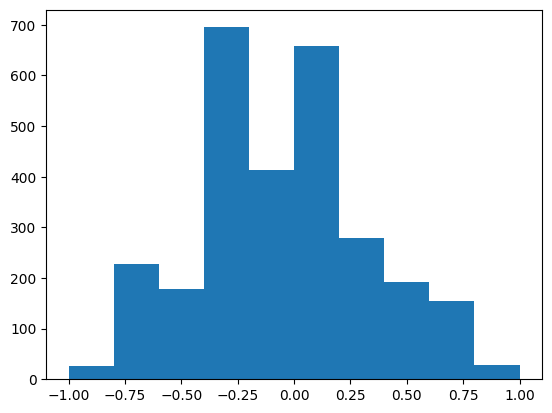

In [ ]:
import matplotlib.pyplot as plt

kendalltau_counter = en_race_hf_rank_comb_valid["kendall_tau"].value_counts()
print(kendalltau_counter)
plt.figure()
plt.hist(en_race_hf_rank_comb_valid["kendall_tau"].values)

Chinese-Race-hf_tf


In [ ]:
zh_race_hftf_tb, zh_race_hftf_rank_comb = results_analysis("race", "zh", "hf_tf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Chinese-Race-hf


In [ ]:
zh_race_hf_tb, zh_race_hf_rank_comb = results_analysis("race", "zh", "hf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Hispanic-Race-hftf


In [ ]:
es_race_hftf_tb, es_race_hftf_rank_comb = results_analysis("race", "es", "hf_tf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Hispanic-Race-hf


In [ ]:
es_race_hf_tb, es_race_hf_rank_comb = results_analysis("race", "es", "hf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

French-Race-hftf


In [ ]:
fr_race_hftf_tb, fr_race_hftf_rank_comb = results_analysis("race", "fr", "hf_tf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

French-Race-hf


In [ ]:
fr_race_hf_tb, fr_race_hf_rank_comb = results_analysis("race", "fr", "hf", 1, {})

/tmp/ipykernel_2078198/2533230487.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/2533230487.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

Combine hftf of four languages


In [ ]:
print(
    len(en_race_hftf_tb.columns),
    len(zh_race_hftf_tb.columns),
    len(es_race_hftf_tb.columns),
    len(fr_race_hftf_tb.columns),
)

34 34 34 34


In [ ]:
print(es_race_hftf_tb["cohere"])

 als                           {'max': ('hispanic', -0.2504517119), 'min': ('...
 mi                            {'max': ('hispanic', -0.666162981), 'min': ('w...
 mnd                           {'max': ('hispanic', -0.449361108), 'min': ('w...
achilles tendinitis            {'max': ('hispanic', -0.941842591), 'min': ('w...
acne                           {'max': ('hispanic', -0.281065525), 'min': ('a...
                                                     ...                        
ulcerative colitis             {'max': ('hispanic', -0.489240469), 'min': ('w...
upper respiratory infection    {'max': ('hispanic', -0.4064842305), 'min': ('...
urinary tract infection        {'max': ('hispanic', -0.3718893537), 'min': ('...
vision problems                {'max': ('hispanic', -0.16309708750000002), 'm...
visual anomalies               {'max': ('hispanic', -0.2679079271), 'min': ('...
Name: cohere, Length: 92, dtype: object


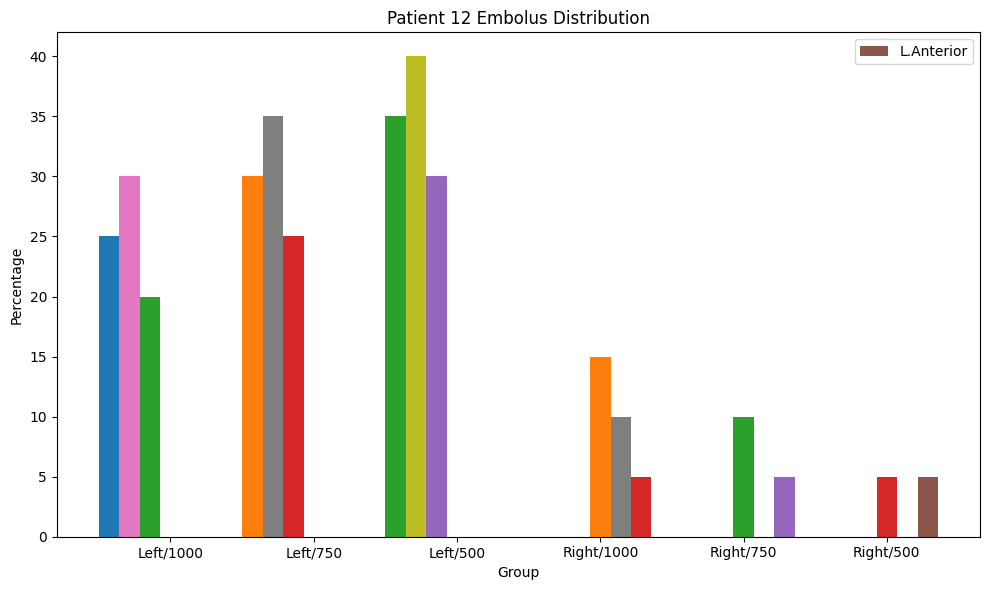

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data for demonstration purposes
# Assume each sublist corresponds to a different stacked bar within the group
data = {
    "Group": [
        "Left/1000",
        "Left/750",
        "Left/500",
        "Right/1000",
        "Right/750",
        "Right/500",
    ],
    "L.Anterior": [25, 30, 35, 0, 0, 0],
    "L.MCA": [30, 35, 40, 0, 0, 0],
    "L.Posterior": [20, 25, 30, 0, 0, 0],
    "R.Anterior": [0, 0, 0, 15, 10, 5],
    "R.MCA": [0, 0, 0, 10, 0, 0],
    "R.Posterior": [0, 0, 0, 5, 5, 5],
}

df = pd.DataFrame(data)
df.set_index("Group", inplace=True)

# Number of unique groups (Left/1000, Left/750, etc.)
num_unique_groups = len(df.index.unique())

# The width of each individual stacked bar
bar_width = 0.1

# The spacing between each group of stacks
group_width = bar_width * (len(df.columns) + 1)

# Positions of the groups on the x-axis
group_indices = np.arange(0, num_unique_groups * group_width, group_width)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Loop through each subgroup (L.Anterior, L.MCA, etc.)
for i, column in enumerate(df.columns):
    subgroup_bottoms = np.zeros(num_unique_groups)
    # Plot each stack within the subgroup
    for j in range(len(df[column])):
        # Determine the position of the bar based on its group and stack order
        position = group_indices[j] + (i * bar_width)
        ax.bar(
            position,
            df[column].iloc[j],
            bar_width,
            bottom=subgroup_bottoms[j],
            label=column if i == 0 else "",
        )
        subgroup_bottoms[j] += df[column].iloc[j]

# Set the position and labels of the X ticks
ax.set_xticks(group_indices + (group_width / 2) - (bar_width / 2))
ax.set_xticklabels(df.index.unique())

# Adding labels and title
ax.set_xlabel("Group")
ax.set_ylabel("Percentage")
ax.set_title("Patient 12 Embolus Distribution")

# Adding legend
# This bit of code ensures that the legend is not repeated
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Show the plot
plt.tight_layout()
plt.show()

Get bar chart for top demographic distribution across all diseases (for race, hftf)


In [ ]:
languages = ["en", "zh", "es", "fr"]

In [ ]:
languages = ["en", "zh", "es", "fr"]


def generate_df_language(race_hftf_tb):
    # Calculate top and bottom race count across all models for en
    model_dist_dict = {}
    for column in race_hftf_tb.columns:
        temp_dict = dict(Counter(race_hftf_tb[column].apply(lambda x: x["max"][0])))
        for race in race_categories:
            if race not in temp_dict:
                temp_dict[race] = 0
        temp_dict = dict(sorted(temp_dict.items()))
        # print(temp_dict)
        model_dist_dict[column] = temp_dict

    model_dist_df = pd.DataFrame(model_dist_dict)
    return model_dist_df


en_model_dist_df = generate_df_language(en_race_hftf_tb)
zh_model_dist_df = generate_df_language(zh_race_hftf_tb)
es_model_dist_df = generate_df_language(es_race_hftf_tb)
fr_model_dist_df = generate_df_language(fr_race_hftf_tb)

In [ ]:
en_model_dist_df

,BioMistral/BioMistral-7B,EleutherAI/pile-t5-base,EleutherAI/pile-t5-large,EleutherAI/pile-t5-xl,EleutherAI/pythia-12b-deduped,EleutherAI/pythia-160m-deduped,EleutherAI/pythia-1b-deduped,EleutherAI/pythia-2.8b-deduped,EleutherAI/pythia-410m-deduped,EleutherAI/pythia-6.9b-deduped,...,meta-llama/Llama-2-70b-chat-hf,meta-llama/Llama-2-70b-hf,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-v0.1,state-spaces/mamba-1.4b,state-spaces/mamba-130m,state-spaces/mamba-2.8b,state-spaces/mamba-2.8b-slimpj,state-spaces/mamba-370m,state-spaces/mamba-790m
asian,14,2,1,6,0,17,28,22,7,2,...,0,10,1,2,37,36,19,37,5,37
black,3,53,1,79,5,12,5,7,6,43,...,6,4,0,6,0,0,30,20,12,0
hispanic,47,0,1,0,30,20,23,20,7,2,...,43,42,0,0,2,0,0,0,9,0
indigenous,9,0,0,0,35,15,1,16,32,42,...,18,4,1,0,48,55,22,14,34,0
pacific islander,2,0,82,5,10,10,34,27,30,1,...,1,1,90,80,5,1,9,0,17,55
white,17,37,7,2,12,18,1,0,10,2,...,24,31,0,4,0,0,12,21,15,0


In [ ]:
print([i for i in en_model_dist_df.columns if "7B" in i or "7b" in i])

['BioMistral/BioMistral-7B', 'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta', 'Qwen/Qwen1.5-7B', 'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-7b', 'allenai/tulu-2-dpo-7b', 'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1']


In [ ]:
mamba = [
    "state-spaces/mamba-130m",
    "state-spaces/mamba-370m",
    "state-spaces/mamba-790m",
    "state-spaces/mamba-1.4b",
    "state-spaces/mamba-2.8b-slimpj",
    "state-spaces/mamba-2.8b",
]
pythia = [
    "EleutherAI/pythia-70m-deduped",
    "EleutherAI/pythia-160m-deduped",
    "EleutherAI/pythia-410m-deduped",
    "EleutherAI/pythia-1b-deduped",
    "EleutherAI/pythia-2.8b-deduped",
    "EleutherAI/pythia-6.9b-deduped",
    "EleutherAI/pythia-12b-deduped",
]
over_70b = [
    "meta-llama/Llama-2-70b-hf",
    "meta-llama/Llama-2-70b-chat-hf",
    "epfl-llm/meditron-70b",
    "allenai/tulu-2-70b",
    "allenai/tulu-2-dpo-70b",
    "Qwen/Qwen1.5-72B",
    "Qwen/Qwen1.5-72B-Chat",
    "gpt-35-turbo-0613",
    "cohere",
]
model_7b = [i for i in en_model_dist_df.columns if "7B" in i or "7b" in i]

Mamba Plot


In [ ]:
def plot_models(model_type, models, rotation=0):
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    x_pos = np.array(
        list(range(0, 2 * len(en_model_dist_df[models].columns), 2))
    ).astype(np.float32)
    print(x_pos)

    labels = list(en_model_dist_df.index)
    colors = ["firebrick", "blue", "green", "orange", "purple", "gray"]
    print(labels)

    for language in ["en", "zh", "es", "fr"]:
        rows = 0
        if language == "en":
            model_dist_df = en_model_dist_df[models]
        elif language == "zh":
            model_dist_df = zh_model_dist_df[models]
        elif language == "es":
            model_dist_df = es_model_dist_df[models]
        elif language == "fr":
            model_dist_df = fr_model_dist_df[models]
        else:
            print("invalid language")
        for i in model_dist_df.iterrows():
            print(i[1].values)
            ax.bar(
                x_pos,
                i[1].values,
                bottom=model_dist_df.iloc[:rows].sum(axis=0),
                color=colors[rows],
                width=0.3,
            )
            rows += 1
        x_pos += 0.4

    lang_labels_pos = []
    start = 0
    for i in range(len(x_pos)):
        temp = []
        lang_start = start
        for _ in range(4):
            temp.append(lang_start)
            lang_start += 0.4
        lang_labels_pos += temp
        start += 2
    print(lang_labels_pos)

    model_labels = []
    for name in models:
        try:
            model_labels.append(name.split("/")[1])
        except:
            model_labels.append(name)

    ax.set_xlabel("model name")
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.set_ylabel("demographic count across disesases")
    sec_x = ax.secondary_xaxis("top")
    sec_x.set_xticks(lang_labels_pos, ["en", "zh", "es", "fr"] * len(models))
    ax.set_xticks(
        np.array(range(0, 2 * len(en_model_dist_df[models].columns), 2)) + 0.6,
        model_labels,
        rotation=rotation,
    )
    # ax.set_xticks(lang_labels_pos, ['en', 'zh', 'es', 'fr']*len(models), minor=True)
    ax.set_title(
        f"Race distribution of top demographic for each {model_type} model across diseases in English (America)"
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        labels=labels,
        labelcolor=colors,
        ncols=6,
    )
    plt.show()

[ 0.  2.  4.  6.  8. 10.]
['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']
[36  5 37 37 37 19]
[ 0 12  0  0 20 30]
[0 9 0 2 0 0]
[55 34  0 48 14 22]
[ 1 17 55  5  0  9]
[ 0 15  0  0 21 12]
[ 0  0  0 27  0  0]
[0 1 0 0 0 0]
[ 0 91  1 65  0  0]
[ 0  0 91  0 92 92]
[92  0  0  0  0  0]
[0 0 0 0 0 0]
[ 0  2 92 92 92 37]
[34  0  0  0  0  0]
[3 0 0 0 0 0]
[10  0  0  0  0 40]
[45 89  0  0  0  0]
[ 0  1  0  0  0 15]
[ 8 56 17 92 92  0]
[ 5  0  0  0  0 25]
[18  0  0  0  0  0]
[10 35  0  0  0 11]
[39  0 75  0  0 56]
[12  1  0  0  0  0]
[0, 0.4, 0.8, 1.2000000000000002, 2, 2.4, 2.8, 3.1999999999999997, 4, 4.4, 4.800000000000001, 5.200000000000001, 6, 6.4, 6.800000000000001, 7.200000000000001, 8, 8.4, 8.8, 9.200000000000001, 10, 10.4, 10.8, 11.200000000000001]


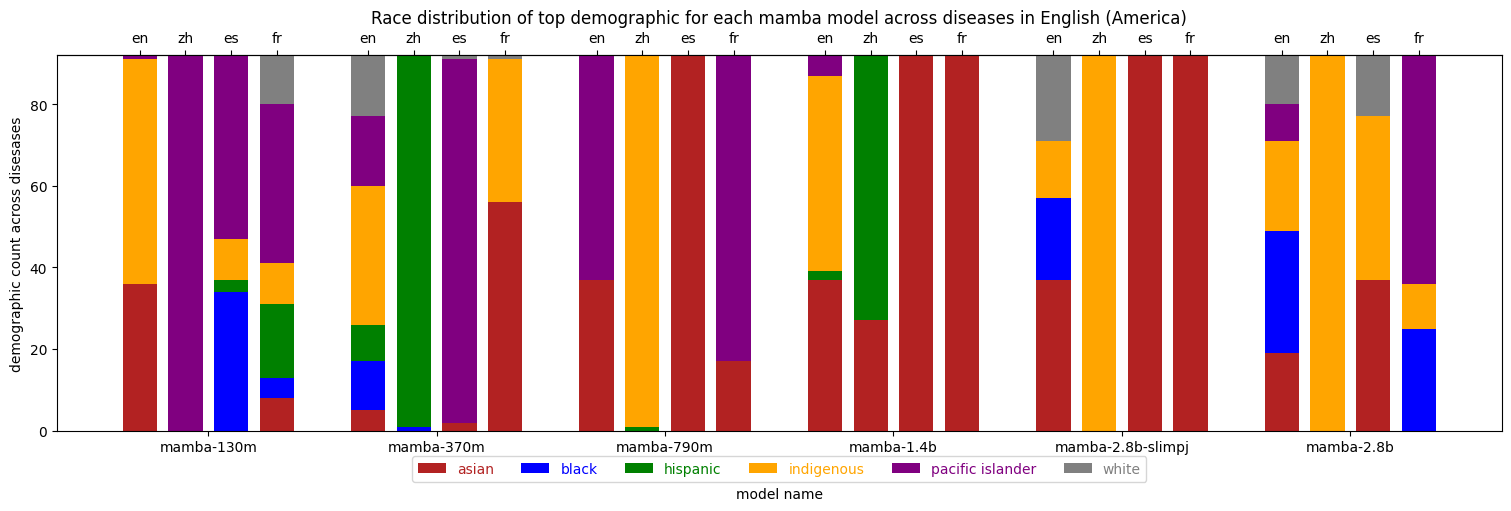

In [ ]:
plot_models("mamba", mamba)

Pythia Plot


[ 0.  2.  4.  6.  8. 10. 12.]
['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']
[ 8 17  7 28 22  2  0]
[21 12  6  5  7 43  5]
[22 20  7 23 20  2 30]
[18 15 32  1 16 42 35]
[ 4 10 30 34 27  1 10]
[19 18 10  1  0  2 12]
[22 10 58  3 43 14  2]
[ 6 35  0  1  3 24  0]
[34 25  0 44 29  1 71]
[ 9  0 18  7 15 37 18]
[12  0  2 33  0 16  0]
[ 9 22 14  4  2  0  1]
[12  3 67 57 66 12 16]
[33 16  2  0  4 14 34]
[12  4 13  2  1  1  2]
[ 8 53  8  1 14 44 20]
[17  7  1 29  1  5  6]
[10  9  1  3  6 16 14]
[ 9 10  4 19 19 13  9]
[20  7  2  3  4 47 28]
[18 13 21 20  7 10  1]
[ 1 29 16  5  3  1 26]
[35 26 39 44 53  2 22]
[ 9  7 10  1  6 19  6]
[0, 0.4, 0.8, 1.2000000000000002, 2, 2.4, 2.8, 3.1999999999999997, 4, 4.4, 4.800000000000001, 5.200000000000001, 6, 6.4, 6.800000000000001, 7.200000000000001, 8, 8.4, 8.8, 9.200000000000001, 10, 10.4, 10.8, 11.200000000000001, 12, 12.4, 12.8, 13.200000000000001]


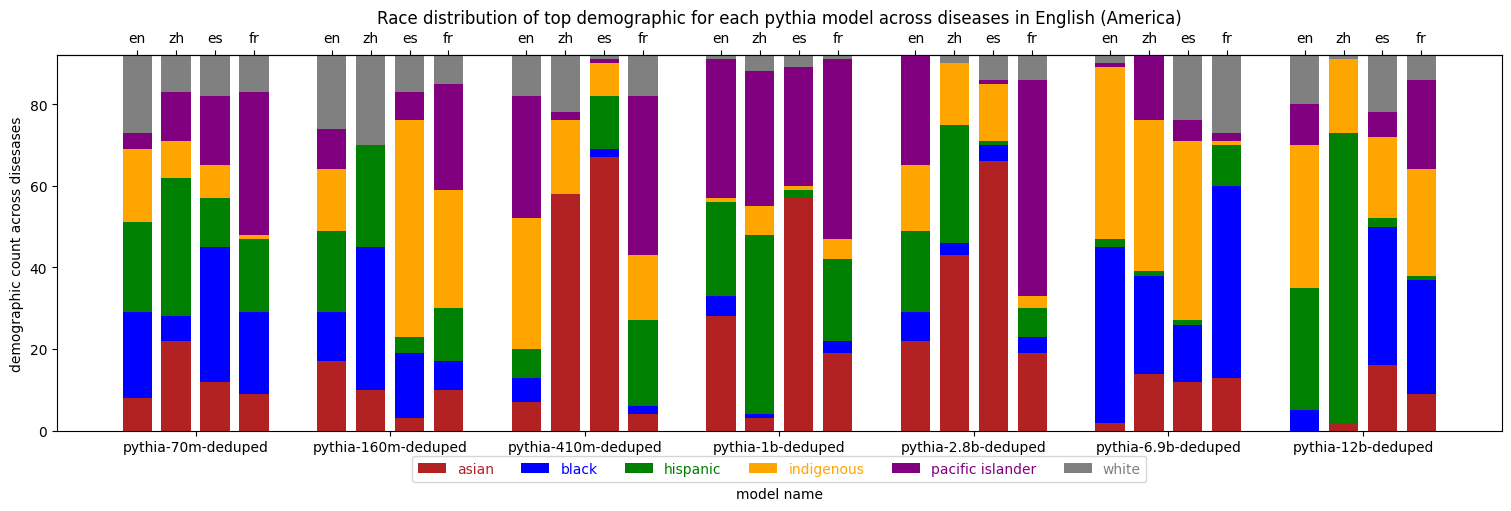

In [ ]:
plot_models("pythia", pythia, rotation=0)

Over-70B plot


[ 0.  2.  4.  6.  8. 10. 12. 14. 16.]
['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']
[10  0 14  0 22  1  1 10  0]
[ 4  6 13  0  7 33 52 28  8]
[42 43  9  1  5  7  0  9 14]
[ 4 18  0  0  0  6  9 23 38]
[ 1  1 32 91 51  3  5  7  1]
[31 24 24  0  7 42 25 15 31]
[46  0 16  3 19  4  1  6  0]
[ 6  1 14 36  3 20 59 29 50]
[ 4  0 16  1  6 51  2  1 42]
[ 6  1  2  4  7  1 11 37  0]
[16  0 14  0 11  4 12  4  0]
[14 90 30 48 46 12  7 15  0]
[ 0  0  7  9 33  0  0  4  0]
[ 0 22 23 44 19  1 12 47  0]
[ 1 11 12 11  3 47 22  7 92]
[ 0 30 18 12  8  0  5 19  0]
[ 0 23 12  1  7 41 47  0  0]
[91  6 20 15 22  3  6 15  0]
[ 0  0  4  0 55  1  0 23  0]
[ 0  1  4 17  5 10 38 16  0]
[ 0  0 21 15  2 13  2  9 92]
[ 0  3  3 16  1  1  9 29  0]
[ 4 86 16  2 11 55 35  3  0]
[88  2 44 42 18 12  8 12  0]
[0, 0.4, 0.8, 1.2000000000000002, 2, 2.4, 2.8, 3.1999999999999997, 4, 4.4, 4.800000000000001, 5.200000000000001, 6, 6.4, 6.800000000000001, 7.200000000000001, 8, 8.4, 8.8, 9.200000000000001, 1

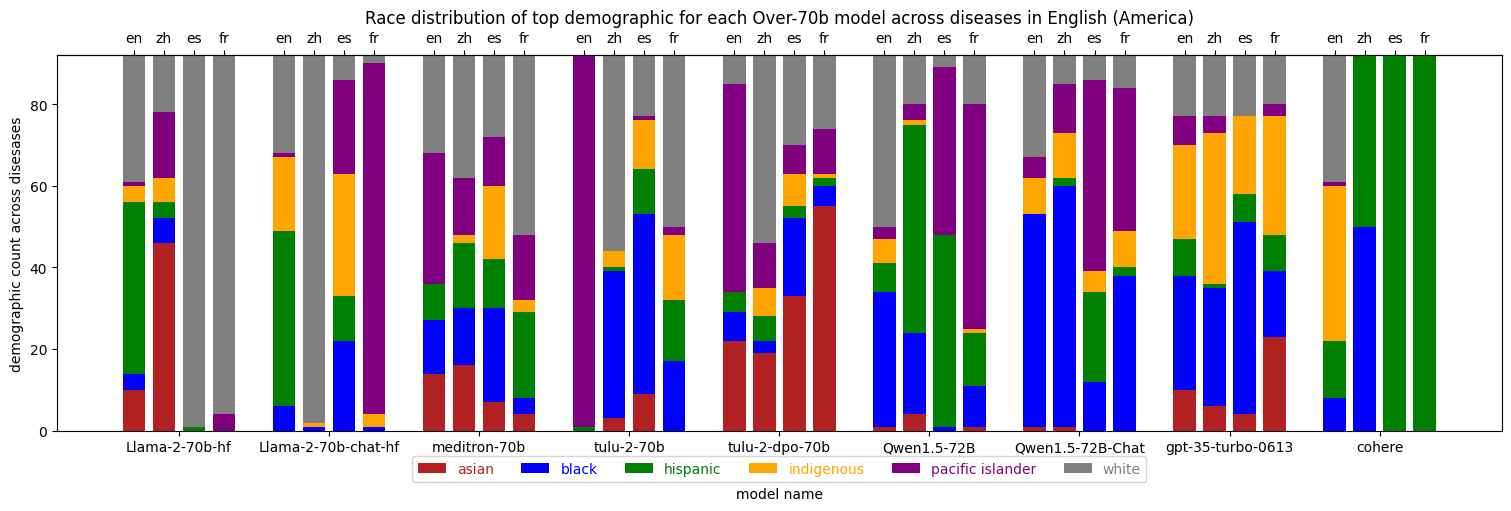

In [ ]:
plot_models("Over-70b", over_70b)

7b plot


[ 0.  2.  4.  6.  8. 10. 12. 14. 16.]
['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']
[14  2  2  1  6  0  0  1  2]
[ 3  0  0 11 25  0  0  0  6]
[47  0  0 14 11  1  1  0  0]
[9 0 0 7 2 0 0 1 0]
[ 2 90 90 32  1 91 91 90 80]
[17  0  0 27 47  0  0  0  4]
[ 1 63  0 15 14 34 10  9  0]
[ 0  0 24  7 13 13 10 30 24]
[ 9 23  9 19 15 12 16 14  5]
[80  4 13  9  0 25 26 11 31]
[ 1  2 27 11  0  6 30 11  1]
[ 1  0 19 31 50  2  0 17 31]
[ 0  8  0  5  1 50 21  1 14]
[ 1 38 10  9  0  5  7 14 24]
[11 10  6 14 50 17 41 38  7]
[44 20 17 11  7  1 14  6 42]
[36  2 56 18 11 17  7 25  0]
[ 0 14  3 35 23  2  2  8  5]
[ 9 15  0  2  0 27  3  5 29]
[ 1 25  1 10  1  3  1 16 19]
[ 5 38 10 14 56 50 12  9  0]
[ 7  9 12 10  6  5 34 17  2]
[45  4 57 26  0  6 40 27  1]
[25  1 12 30 29  1  2 18 41]
[0, 0.4, 0.8, 1.2000000000000002, 2, 2.4, 2.8, 3.1999999999999997, 4, 4.4, 4.800000000000001, 5.200000000000001, 6, 6.4, 6.800000000000001, 7.200000000000001, 8, 8.4, 8.8, 9.200000000000001, 10, 10.4, 

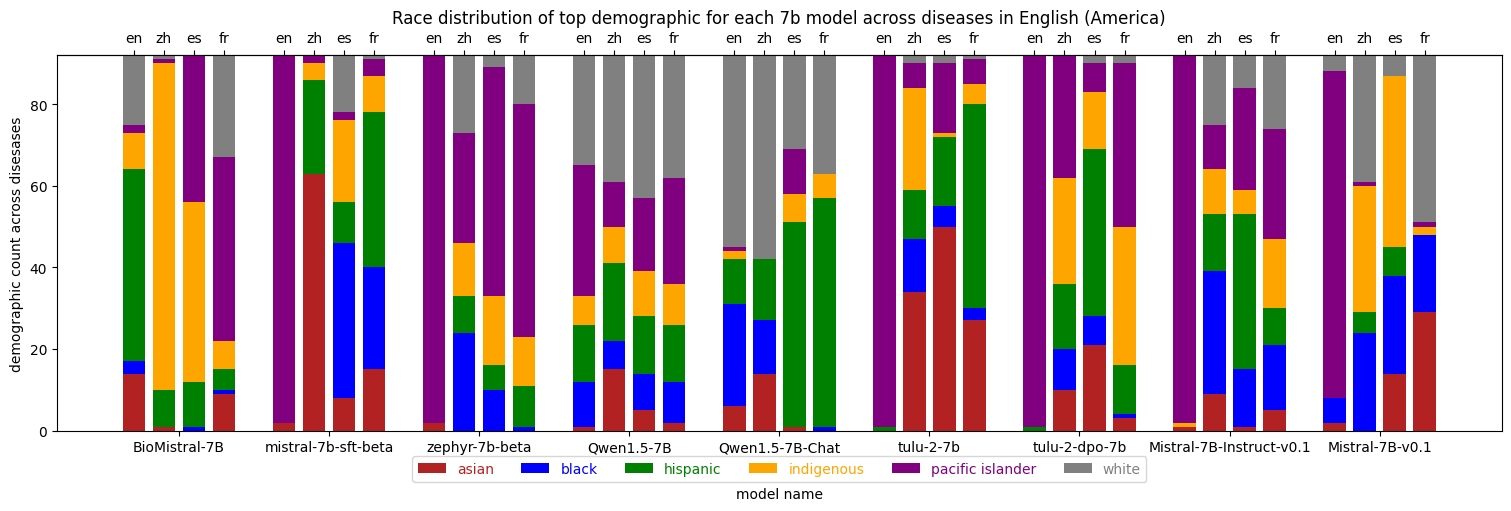

In [ ]:
plot_models("7b", model_7b)

Get diagram for non-America case (en, hftf, race)


/tmp/ipykernel_2078198/1295373310.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/1295373310.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/1295373310.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_2078198/1295373310.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass

{'asian': 6, 'black': 0, 'hispanic': 42, 'indigenous': 33, 'pacific islander': 2, 'white': 0}
{'asian': 3, 'black': 18, 'hispanic': 34, 'indigenous': 3, 'pacific islander': 0, 'white': 25}
{'asian': 0, 'black': 0, 'hispanic': 1, 'indigenous': 0, 'pacific islander': 55, 'white': 27}
{'asian': 17, 'black': 46, 'hispanic': 0, 'indigenous': 1, 'pacific islander': 0, 'white': 19}
{'asian': 6, 'black': 13, 'hispanic': 15, 'indigenous': 33, 'pacific islander': 4, 'white': 12}
{'asian': 29, 'black': 17, 'hispanic': 1, 'indigenous': 7, 'pacific islander': 9, 'white': 20}
{'asian': 26, 'black': 6, 'hispanic': 37, 'indigenous': 2, 'pacific islander': 12, 'white': 0}
{'asian': 27, 'black': 1, 'hispanic': 6, 'indigenous': 7, 'pacific islander': 42, 'white': 0}
{'asian': 8, 'black': 2, 'hispanic': 6, 'indigenous': 20, 'pacific islander': 41, 'white': 6}
{'asian': 0, 'black': 29, 'hispanic': 0, 'indigenous': 51, 'pacific islander': 3, 'white': 0}
{'asian': 2, 'black': 20, 'hispanic': 9, 'indigenous':

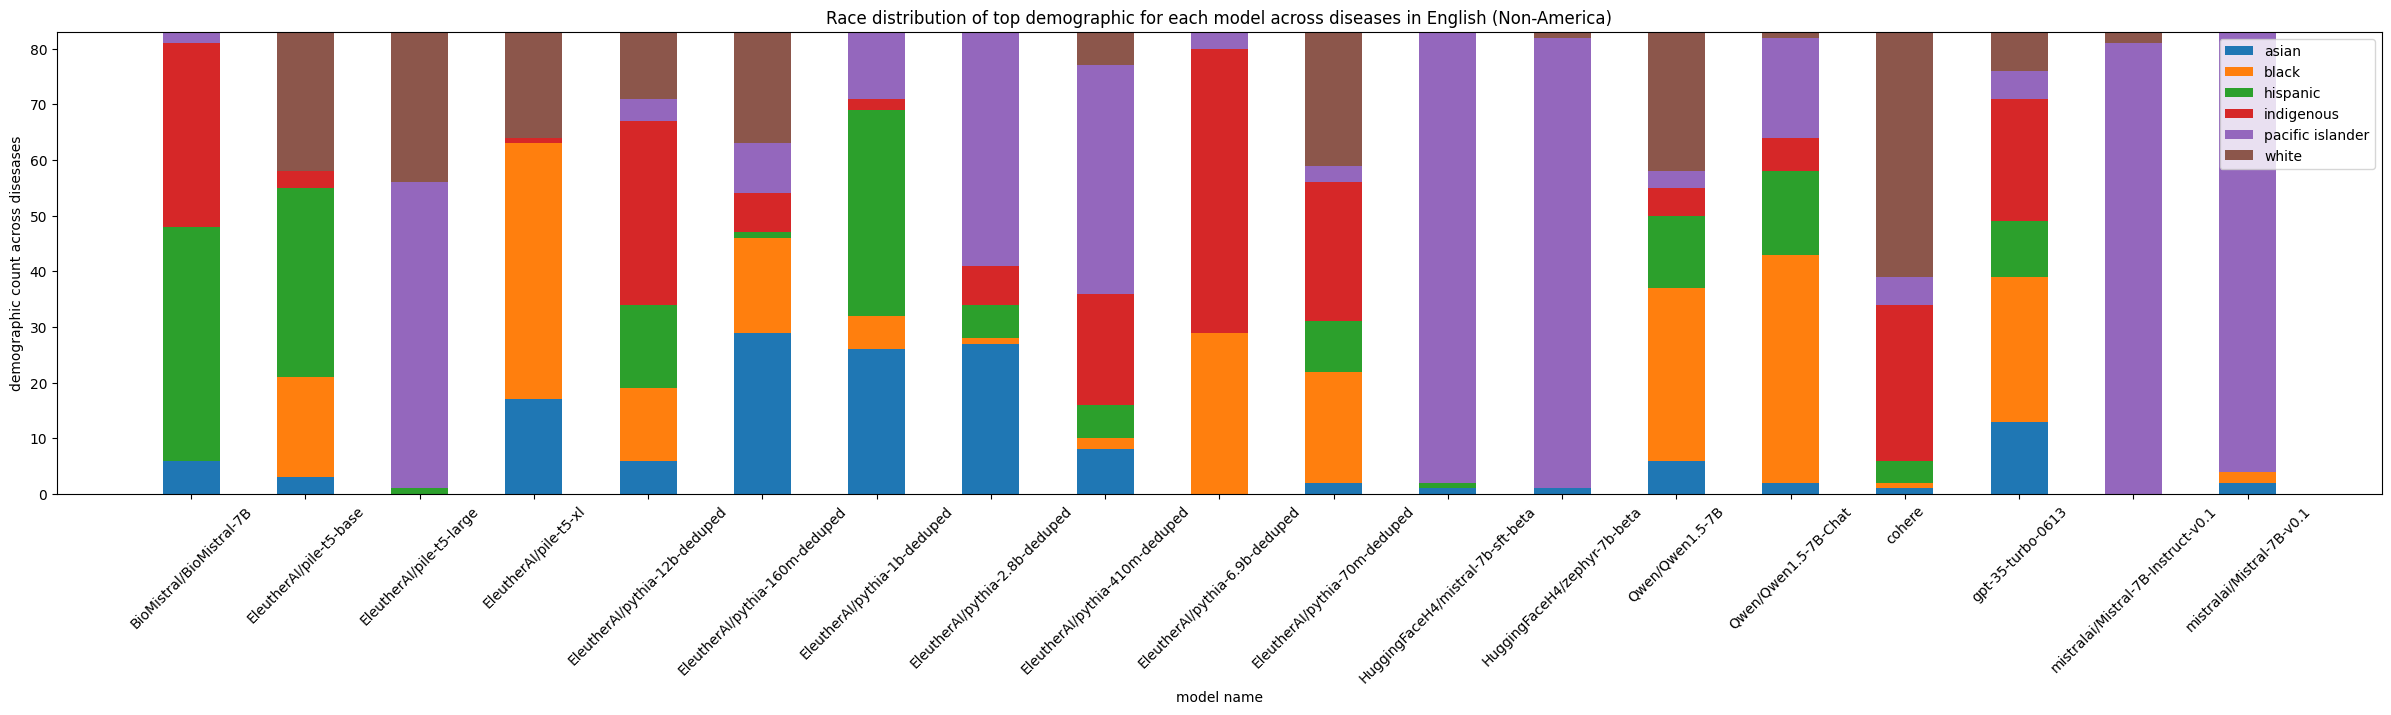

In [ ]:
en_race_hftf_na_tb, _ = results_analysis("race", "en", "hf_tf", 0, {})
en_model_dist_na_df = generate_df_language(en_race_hftf_na_tb)
plt.figure(figsize=(30, 6))
x_pos = np.array(list(range(len(en_model_dist_na_df.columns)))).astype(np.float32)
rows = 0
for i in en_model_dist_na_df.iterrows():
    print(i[1].values)
    plt.bar(
        x_pos,
        i[1].values,
        bottom=en_model_dist_na_df.iloc[:rows].sum(axis=0),
        label=labels[row],
        color=colors[row],
        width=0.5,
    )
    rows += 1

plt.xlabel("model name")
plt.ylabel("demographic count across disesases")
plt.xticks(
    range(len(en_model_dist_na_df.columns)), en_model_dist_na_df.columns, rotation=45
)
plt.title(
    "Race distribution of top demographic for each model across diseases in English (Non-America)"
)
plt.legend()
plt.show()

In [ ]:
print(en_model_dist_na_df.iloc[:2].sum(axis=0))

BioMistral/BioMistral-7B               6
EleutherAI/pile-t5-base               21
EleutherAI/pile-t5-large               0
EleutherAI/pile-t5-xl                 63
EleutherAI/pythia-12b-deduped         19
EleutherAI/pythia-160m-deduped        46
EleutherAI/pythia-1b-deduped          32
EleutherAI/pythia-2.8b-deduped        28
EleutherAI/pythia-410m-deduped        10
EleutherAI/pythia-6.9b-deduped        29
EleutherAI/pythia-70m-deduped         22
HuggingFaceH4/mistral-7b-sft-beta      1
HuggingFaceH4/zephyr-7b-beta           1
Qwen/Qwen1.5-7B                       37
Qwen/Qwen1.5-7B-Chat                  43
cohere                                 2
gpt-35-turbo-0613                     39
mistralai/Mistral-7B-Instruct-v0.1     0
mistralai/Mistral-7B-v0.1              4
dtype: int64


In [ ]:
en_model_dist_na_df

,BioMistral/BioMistral-7B,EleutherAI/pile-t5-base,EleutherAI/pile-t5-large,EleutherAI/pile-t5-xl,EleutherAI/pythia-12b-deduped,EleutherAI/pythia-160m-deduped,EleutherAI/pythia-1b-deduped,EleutherAI/pythia-2.8b-deduped,EleutherAI/pythia-410m-deduped,EleutherAI/pythia-6.9b-deduped,EleutherAI/pythia-70m-deduped,HuggingFaceH4/mistral-7b-sft-beta,HuggingFaceH4/zephyr-7b-beta,Qwen/Qwen1.5-7B,Qwen/Qwen1.5-7B-Chat,cohere,gpt-35-turbo-0613,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-v0.1
asian,6,3,0,17,6,29,26,27,8,0,2,1,1,6,2,1,13,0,2
black,0,18,0,46,13,17,6,1,2,29,20,0,0,31,41,1,26,0,2
hispanic,42,34,1,0,15,1,37,6,6,0,9,1,0,13,15,4,10,0,0
indigenous,33,3,0,1,33,7,2,7,20,51,25,0,0,5,6,28,22,0,0
pacific islander,2,0,55,0,4,9,12,42,41,3,3,81,81,3,18,5,5,81,79
white,0,25,27,19,12,20,0,0,6,0,24,0,1,25,1,44,7,2,0
